# Modeling

## Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import umap.umap_ as umap
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import f_oneway




/Users/vlad_ivanchuk/opt/anaconda3/envs/cs109a/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Data Preparation

In [2]:
# Load features to be used for embeddings
features_df = pd.read_csv('../data/preprocessed/features_df.csv')
geometric_features = ["aspect_ratio", 'subject_size', 'subject_pos_x', 'subject_pos_y', "horizontal_line_count", "vertical_line_count", 
                      "diagonal_line_count", "leading_line_count", "leading_lines_average_angle"]

# Identify continuous and categorical columns for the whole dataset
continuous_cols = [col for col in features_df.columns if not col.startswith('scene_') and col != 'img']
categorical_cols = [col for col in features_df.columns if col.startswith('scene_')]

# Apply scaling to continuous features before splitting
scaler = StandardScaler()
features_df[continuous_cols] = scaler.fit_transform(features_df[continuous_cols])

### Imputing Missing Values
Since I cannot apply dimensionality reduction methods like PCA to a manifold dataset that has missing entries in columns, I decide to impute missing values from the `leading_lines_average_angle` columns. In considering the best approach to imputation, note that the value of 0 represents an image where the leading lines are strictly horizontal or where the oppositely-oriented leading lines' angles cancel out to 0, so I cannot simply impute 0s for missing values as that would introduce bias into the rows with missing values. Instead, I decide to proceed with kNN-imputation of missing values since this would mean the model imputes the values based on its closest neighbors based on non-empty features, such as `subject_size`, `subject_pos_x`, `subject_pos_y`. This makes a lot of sense since, with missing leading lines annotations and therefore missing average angle, we want the image to be represented closely on the manifold to other images that have similar subject positioning features, as this is the only remaining set of geometric descriptors of image composition available.

In [3]:
# Define the columns for the kNN Imputer to work on
impute_columns = ['subject_size', 'subject_pos_x', 'subject_pos_y', 'leading_lines_average_angle']

# Initialize the KNN Imputer
imputer = KNNImputer(n_neighbors=5, weights="uniform")

# Perform imputation on the specified columns
features_df[impute_columns] = imputer.fit_transform(features_df[impute_columns])

In [4]:
# Split the scaled dataframe into geometric and combined features datasets
X_geometric = features_df[geometric_features]
X_combined = features_df.drop(['img'], axis=1)

# Load photo composition evaluation scores
scores_df = pd.read_csv('../data/preprocessed/scores_df.csv')
y = scores_df[scores_df["img"] == features_df["img"]]["mean"].values

In [5]:
print("X_geometric (only geometric embedding features):")
display(X_geometric.head(5))
print("X_combined (combined embedding features):")
display(X_combined.head(5))
print("y (composition scores):")
print(y[:5])

X_geometric (only geometric embedding features):


aspect_ratio  subject_size  subject_pos_x  subject_pos_y  \
0     -2.241256     -0.413203       1.112971       0.249596   
1      0.481322      0.422774      -0.967028      -0.683493   
2      0.517491     -1.339052      -0.735486       0.481492   
3      0.481322      0.550922       1.263791      -0.713645   
4      0.481322      0.293036       1.499785      -0.466392   

   horizontal_line_count  vertical_line_count  diagonal_line_count  \
0              -0.610761            -0.400816            -0.587983   
1              -0.610761            -0.400816             1.458071   
2              -0.610761            -0.400816             1.458071   
3               0.281199            -0.400816            -0.587983   
4              -0.610761            -0.400816            -0.587983   

   leading_line_count  leading_lines_average_angle  
0           -0.708959                     0.220766  
1           -0.320146                    -0.518476  
2           -0.320146                     0.072743  
3           -0.320146                    -0.319501  
4           -0.708959                     0.236938

X_combined (combined embedding features):


aspect_ratio  subject_size  subject_pos_x  subject_pos_y  \
0     -2.241256     -0.413203       1.112971       0.249596   
1      0.481322      0.422774      -0.967028      -0.683493   
2      0.517491     -1.339052      -0.735486       0.481492   
3      0.481322      0.550922       1.263791      -0.713645   
4      0.481322      0.293036       1.499785      -0.466392   

   horizontal_line_count  vertical_line_count  diagonal_line_count  \
0              -0.610761            -0.400816            -0.587983   
1              -0.610761            -0.400816             1.458071   
2              -0.610761            -0.400816             1.458071   
3               0.281199            -0.400816            -0.587983   
4              -0.610761            -0.400816            -0.587983   

   leading_line_count  leading_lines_average_angle  scene_animal  ...  \
0           -0.708959                     0.220766             0  ...   
1           -0.320146                    -0.518476             0  ...   
2           -0.320146                     0.072743             0  ...   
3           -0.320146                    -0.319501             0  ...   
4           -0.708959                     0.236938             0  ...   

   exposure  color_vivid  color_harmony  object_emphasis  balancing_elements  \
0  0.583907    -0.002570      -0.844971        -0.055905           -1.089023   
1  0.006302     0.562240      -0.146862         0.736387           -0.183678   
2 -0.571303    -1.697002      -0.146862        -0.452052           -0.183678   
3  1.161512    -0.002570       1.249355        -0.452052           -0.183678   
4  0.006302     0.562240      -0.146862        -1.640490           -0.183678   

   symmetry  repetition  rule_of_thirds  motion_blur  depth_of_field  
0 -0.166429   -0.367243       -0.497834     0.075648        0.457963  
1 -0.166429   -0.367243        1.049936     0.075648        2.436790  
2 -0.166429   -0.367243        0.276051     0.075648        0.457963  
3 -0.166429   -0.367243       -2.045604     0.075648       -0.201646  
4 -0.166429   -0.367243        0.276051     0.075648       -0.201646  

[5 rows x 29 columns]

y (composition scores):
[2.8 3.2 3.2 2.4 2.4]


## Dimensionality Reduction of Geometric Feature Embeddings

### PCA

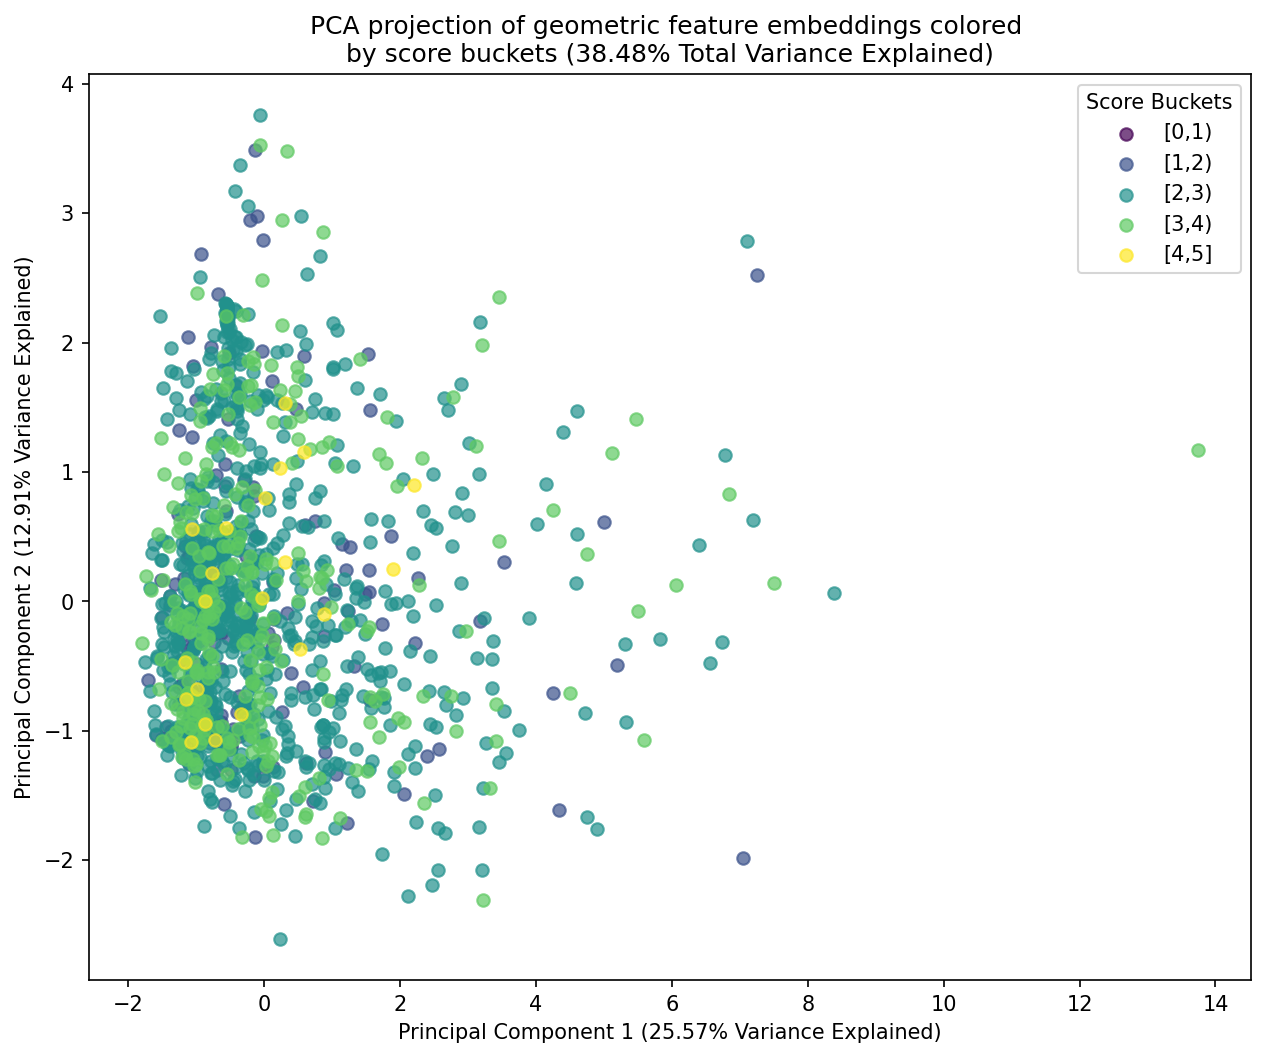

In [6]:
# Convert y to a pandas Series
y_series = pd.Series(y)

# Reduce dimensions with t-SNE
pca_geometric = PCA(n_components=2, random_state=42)
pca_geometric_results = pca_geometric.fit_transform(X_geometric)

# Create buckets for the scores
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the t-SNE output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# We will plot each category separately to have control over the labels and colors
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    # Select data points that belong to the current category
    mask = (buckets == category)
    plt.scatter(pca_geometric_results[mask, 0], pca_geometric_results[mask, 1], color=colors[i], label=category, alpha=0.7)

# Calculate the percentage of variance explained by each of the principal components
variance_explained = pca_geometric.explained_variance_ratio_ * 100  # Convert to percentage
total_variance = variance_explained.sum()  # Calculate total variance explained

# Update the plot with detailed axes labels and title including variance explained
plt.xlabel(f'Principal Component 1 ({variance_explained[0]:.2f}% Variance Explained)')
plt.ylabel(f'Principal Component 2 ({variance_explained[1]:.2f}% Variance Explained)')
plt.title(f'PCA projection of geometric feature embeddings colored \nby score buckets ({total_variance:.2f}% Total Variance Explained)')
plt.legend(title='Score Buckets')  # Add a legend with a title
plt.savefig('../visualizations/PCA_Geometric.png')
plt.show()


### TSNE

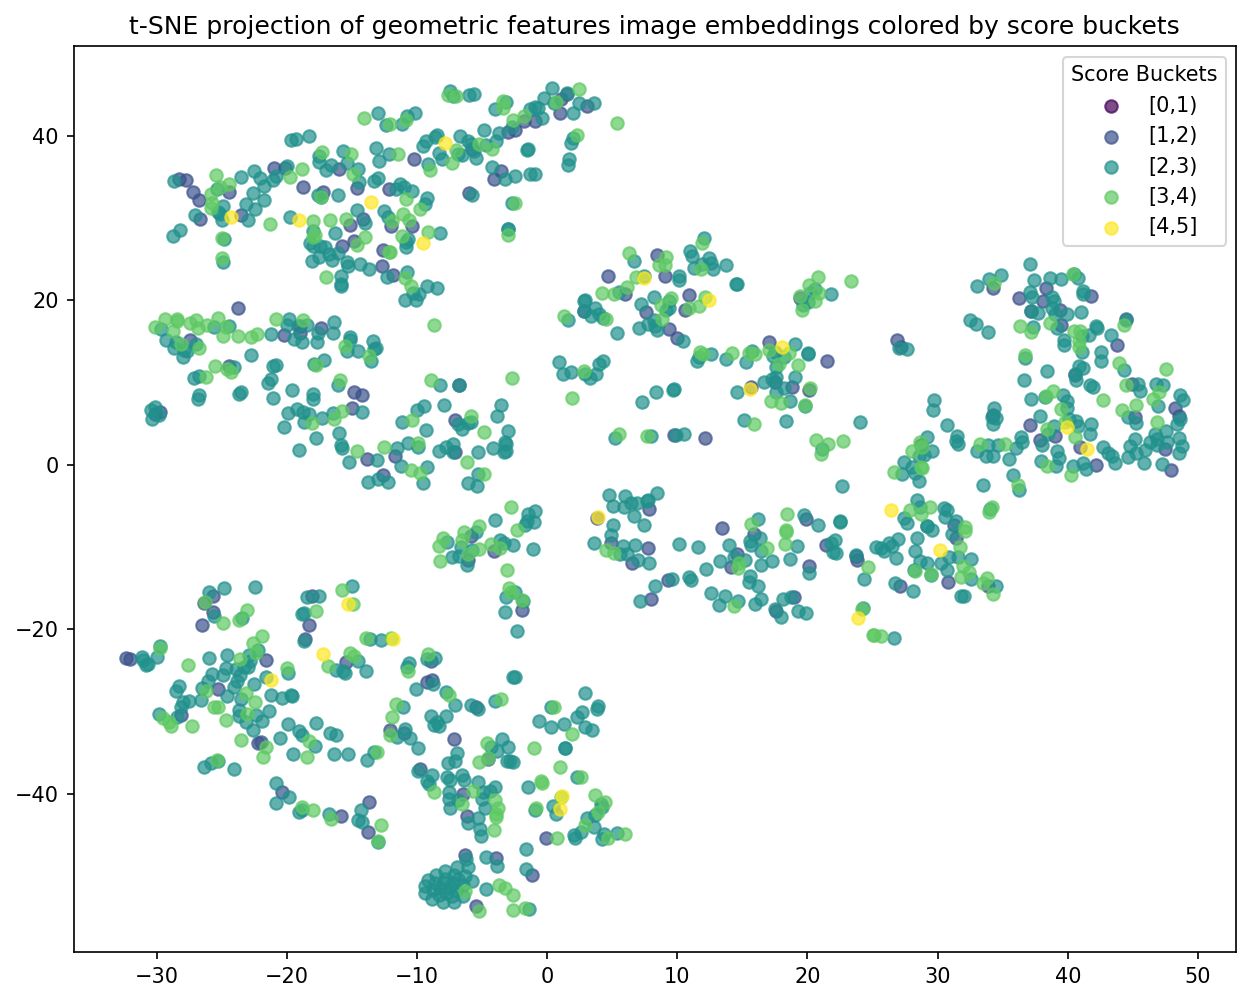

In [7]:
# Convert y to a pandas Series
y_series = pd.Series(y)

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_geometric_results = tsne.fit_transform(X_geometric)

# Create buckets for the scores
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the t-SNE output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# We will plot each category separately to have control over the labels and colors
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    # Select data points that belong to the current category
    mask = (buckets == category)
    plt.scatter(tsne_geometric_results[mask, 0], tsne_geometric_results[mask, 1], color=colors[i], label=category, alpha=0.7)

plt.title('t-SNE projection of geometric features image embeddings colored by score buckets')
plt.legend(title='Score Buckets')  # Add a legend with a title
plt.savefig('../visualizations/TSNE_Geometric.png')
plt.show()

### UMAP

/Users/vlad_ivanchuk/opt/anaconda3/envs/cs109a/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


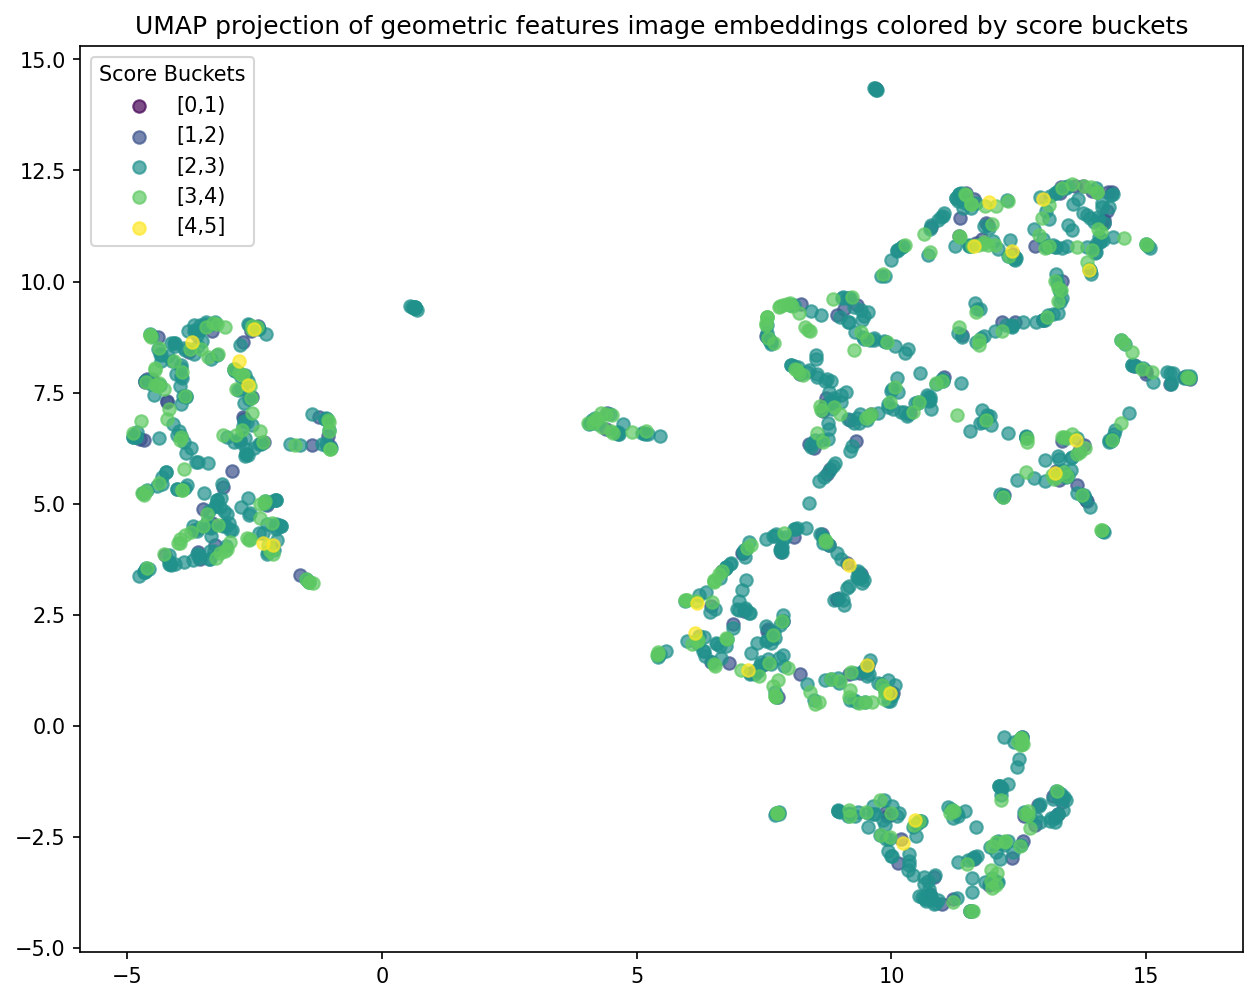

In [8]:
# Reduce dimensions with UMAP
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)
umap_geometric_results = umap_model.fit_transform(X_geometric)

# Bucket the scores as before
y_series = pd.Series(y)
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the UMAP output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# Plot each category separately
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    mask = (buckets == category)
    plt.scatter(umap_geometric_results[mask, 0], umap_geometric_results[mask, 1], color=colors[i], label=category, alpha=0.7)

plt.title('UMAP projection of geometric features image embeddings colored by score buckets')
plt.legend(title='Score Buckets')
plt.savefig('../visualizations/UMAP_Geometric.png')
plt.show()


## Dimensionality Reduction of Combined Feature Embeddings

### PCA

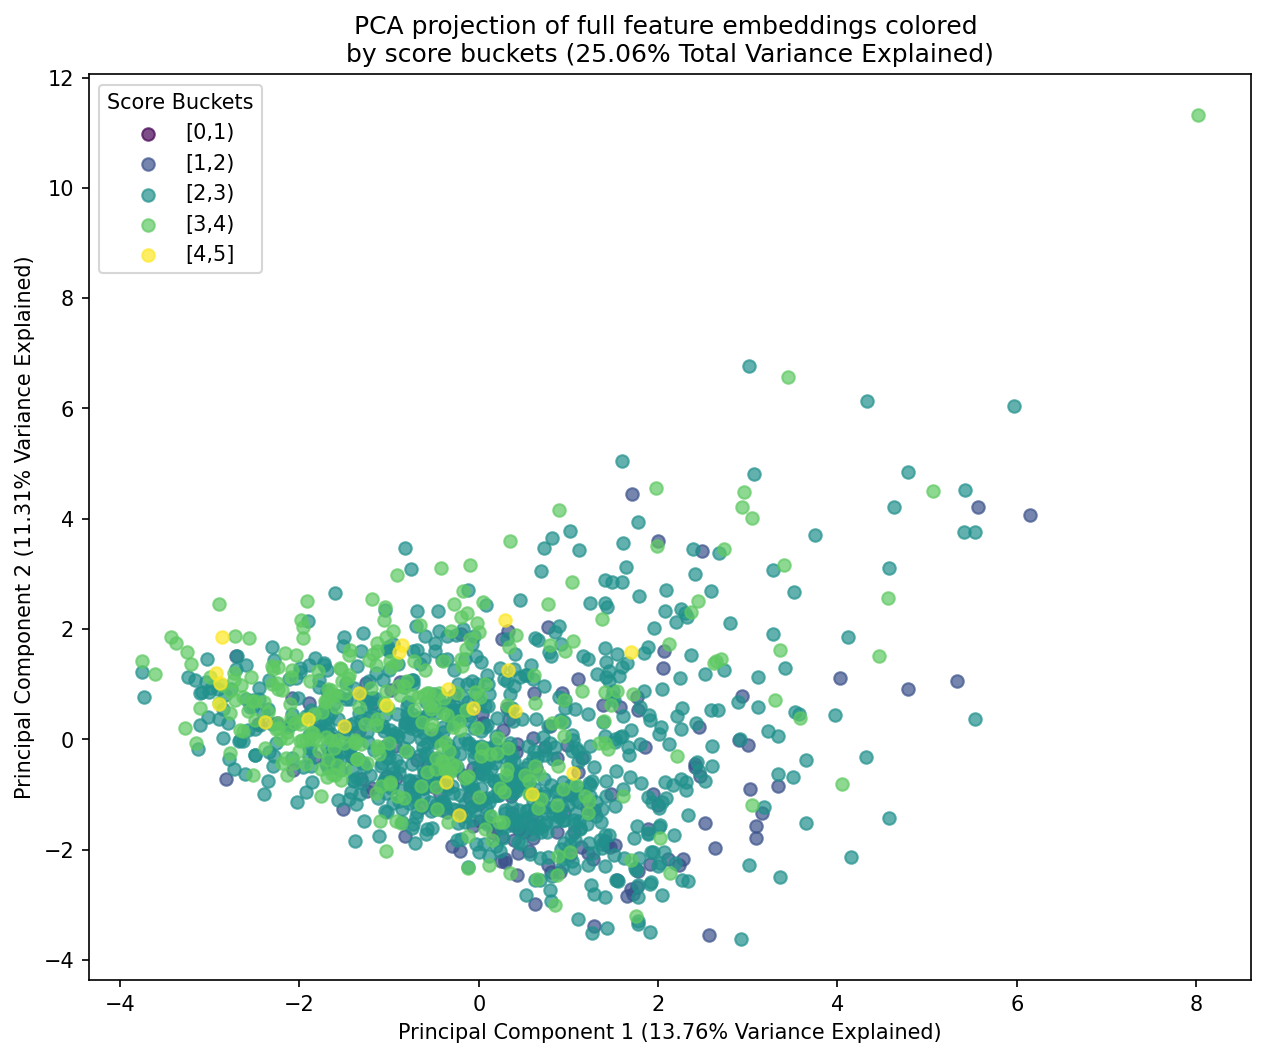

In [9]:
# Convert y to a pandas Series
y_series = pd.Series(y)

# Reduce dimensions with t-SNE
pca_combined = PCA(n_components=2, random_state=42)
pca_combined_results = pca_combined.fit_transform(X_combined)

# Create buckets for the scores
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the t-SNE output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# We will plot each category separately to have control over the labels and colors
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    # Select data points that belong to the current category
    mask = (buckets == category)
    plt.scatter(pca_combined_results[mask, 0], pca_combined_results[mask, 1], color=colors[i], label=category, alpha=0.7)

# Calculate the percentage of variance explained by each of the principal components
variance_explained = pca_combined.explained_variance_ratio_ * 100  # Convert to percentage
total_variance = variance_explained.sum()  # Calculate total variance explained

# Update the plot with detailed axes labels and title including variance explained
plt.xlabel(f'Principal Component 1 ({variance_explained[0]:.2f}% Variance Explained)')
plt.ylabel(f'Principal Component 2 ({variance_explained[1]:.2f}% Variance Explained)')
plt.title(f'PCA projection of full feature embeddings colored \nby score buckets ({total_variance:.2f}% Total Variance Explained)')
plt.legend(title='Score Buckets')  # Add a legend with a title
plt.savefig('../visualizations/PCA_Combined.png')
plt.show()


### TSNE

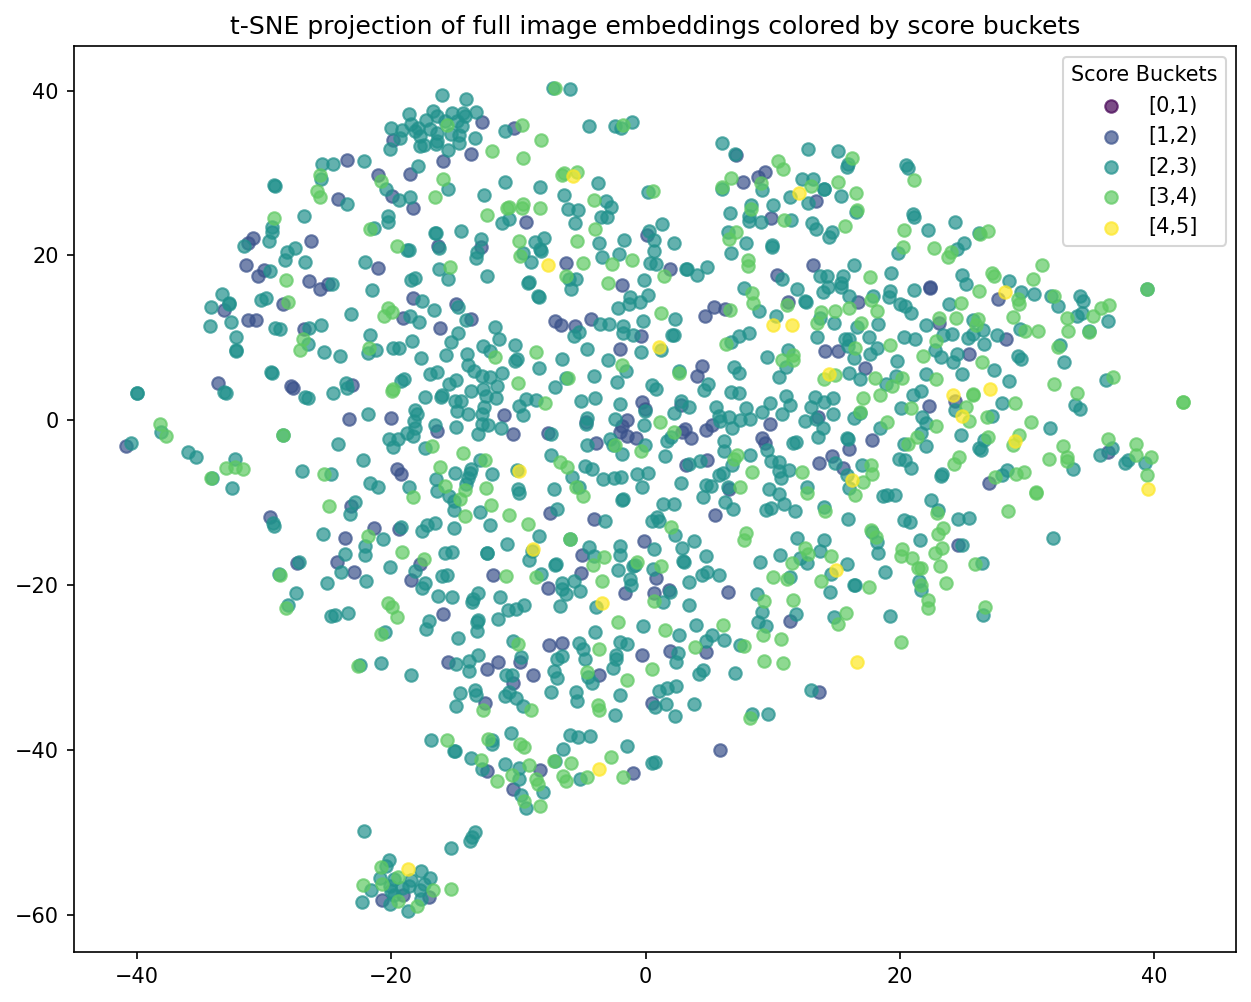

In [10]:
# Convert y to a pandas Series
y_series = pd.Series(y)

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_combined_results = tsne.fit_transform(X_combined)

# Create buckets for the scores
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the t-SNE output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# We will plot each category separately to have control over the labels and colors
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    # Select data points that belong to the current category
    mask = (buckets == category)
    plt.scatter(tsne_combined_results[mask, 0], tsne_combined_results[mask, 1], color=colors[i], label=category, alpha=0.7)

plt.title('t-SNE projection of full image embeddings colored by score buckets')
plt.legend(title='Score Buckets')  # Add a legend with a title
plt.savefig('../visualizations/TSNE_Combined.png')
plt.show()


### UMAP

/Users/vlad_ivanchuk/opt/anaconda3/envs/cs109a/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


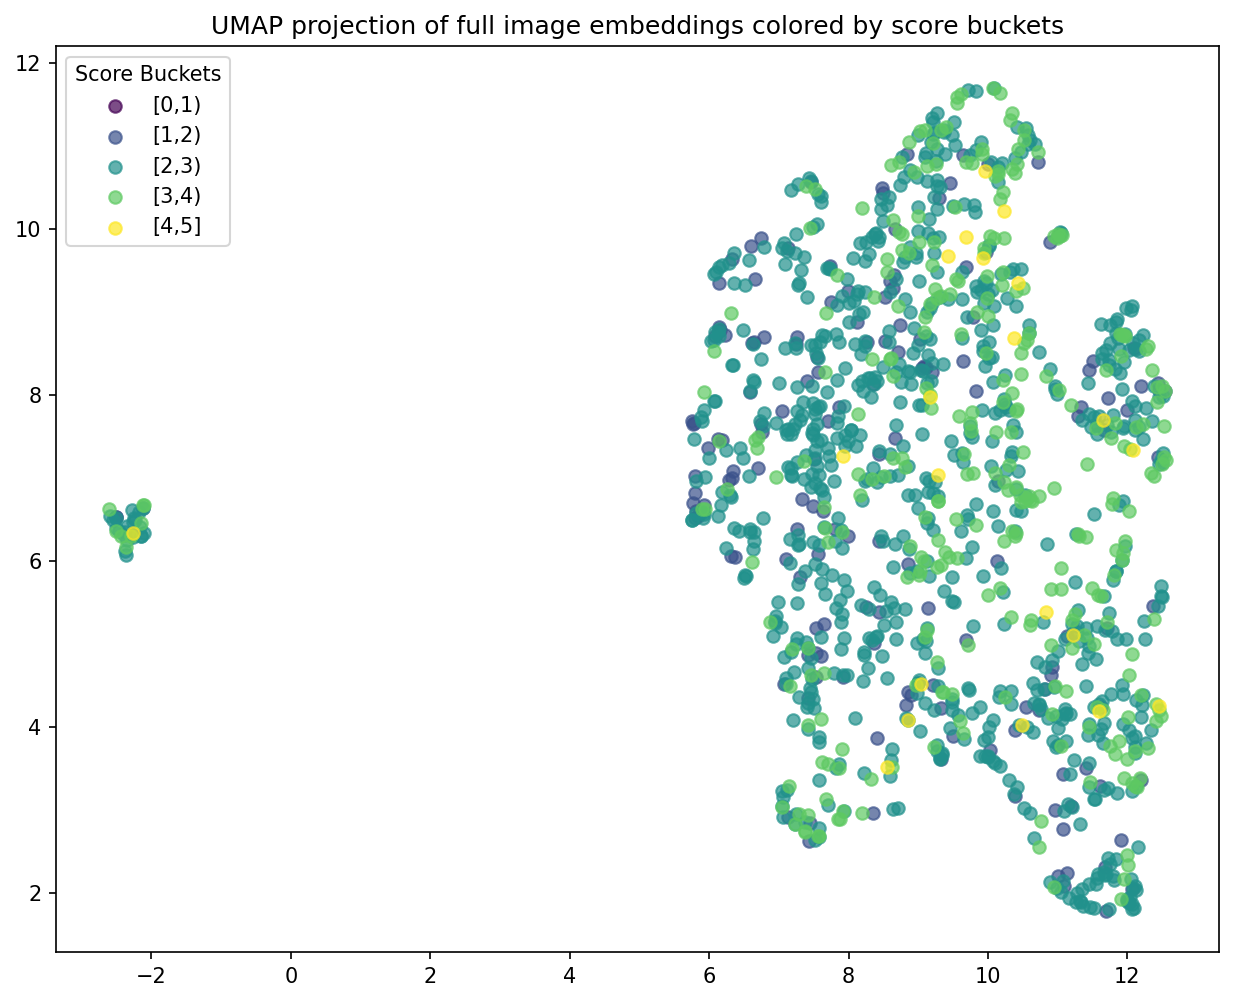

In [11]:
# Reduce dimensions with UMAP
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.1, n_components=2, random_state=42)
umap_combined_results = umap_model.fit_transform(X_combined)

# Bucket the scores as before
y_series = pd.Series(y)
buckets = pd.cut(y_series, bins=[0, 1, 2, 3, 4, 5], include_lowest=True, labels=['[0,1)', '[1,2)', '[2,3)', '[3,4)', '[4,5]'])

# Plot the UMAP output, coloring by composition score buckets
plt.figure(figsize=(10, 8), dpi=150)
# Plot each category separately
colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(buckets.cat.categories)))
for i, category in enumerate(buckets.cat.categories):
    mask = (buckets == category)
    plt.scatter(umap_combined_results[mask, 0], umap_combined_results[mask, 1], color=colors[i], label=category, alpha=0.7)

plt.title('UMAP projection of full image embeddings colored by score buckets')
plt.legend(title='Score Buckets')
plt.savefig('../visualizations/UMAP_Combined.png')
plt.show()

## Clustering of Low-dimensional Geometric Feature Embeddings

In [12]:
# Helper functions for plotting

def determine_optimal_clusters(data, technique='PCA', features='Geometric', max_clusters=10):
    """
    Applies KMeans clustering to dimensionality reduction results to determine the optimal number of clusters.
    Plots include an elbow plot for inertia and a plot for silhouette scores.
    
    Args:
    - data (np.ndarray): The low-dimensional data from PCA, t-SNE, or UMAP.
    - technique (str): The dimensionality reduction technique used ('PCA', 't-SNE', 'UMAP').
    - features (str): Type of features used in embeddings ('Geometric' or 'Combined').
    - max_clusters (int): Maximum number of clusters to test.
    """
    inertia = []
    silhouettes = []
    K = range(2, max_clusters + 1)  # Test from 2 to max_clusters clusters

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        # Calculate silhouette scores only for k greater than 1
        silhouette_avg = silhouette_score(data, kmeans.labels_)
        silhouettes.append(silhouette_avg)

    # Plotting the Elbow graph to find the optimal number of clusters
    fig, ax = plt.subplots(1, 2, figsize=(16, 5), dpi=150)

    # Inertia plot
    ax[0].plot(K, inertia, 'bo-')
    ax[0].set_xlabel('Number of Clusters, k')
    ax[0].set_ylabel('Inertia')
    ax[0].set_title(f'Elbow Method For Optimal k for Clustering of\n{technique} Reduced {features} Feature Embeddings')

    # Silhouette score plot
    ax[1].plot(K, silhouettes, 'go-')  # Make sure K has the correct length here
    ax[1].set_xlabel('Number of Clusters, k')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].set_title('Silhouette Scores For Different k')

    plt.tight_layout()
    plt.savefig(f'../visualizations/best_k_{technique}_{features}.png')
    plt.show()


def plot_clusters(data, y_series, num_clusters, technique='PCA', features='Geometric', pca_object=None):
    """
    Applies KMeans clustering to dimensionality reduction results and plots the clusters.
    Plots include a scatter plot of the results colored by cluster and a violin plot of the scores.
    
    Args:
    - data (np.ndarray): The low-dimensional data from PCA, t-SNE, or UMAP.
    - y_series (pd.Series): Series containing composition scores corresponding to data.
    - num_clusters (int): Number of clusters to form.
    - technique (str): The dimensionality reduction technique used ('PCA', 't-SNE', 'UMAP').
    - features (str): Type of features used in embeddings ('Geometric' or 'Combined').
    - pca_object (PCA): Optional PCA object if variance explained needs to be shown.
    """
    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)

    # Attach the cluster information to a new DataFrame as well as the original DataFrame
    cluster_data = pd.DataFrame(data)
    cluster_data['Cluster'] = clusters
    cluster_data['Scores'] = y_series
    features_df[f"Cluster_{technique}_{features}"] = clusters

    # Define a color palette
    palette = sns.color_palette("Set1", n_colors=num_clusters)
    cluster_colors = {i: palette[i] for i in range(num_clusters)}

    # Create a DataFrame to calculate medians and sort clusters
    median_scores = cluster_data.groupby('Cluster')['Scores'].median().sort_values()
    sorted_clusters = median_scores.index.tolist()

    # Start a new figure with subplots
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), dpi=150)

    # Scatter plot of the dimensionality reduced data
    ax[0].scatter(data[:, 0], data[:, 1], c=[cluster_colors[label] for label in clusters], alpha=0.7)

    # Adjust labels based on the dimensionality reduction technique
    if technique == 'PCA' and pca_object is not None:
        variance_explained = np.cumsum(np.round(pca_object.explained_variance_ratio_, decimals=4) * 100)
        ax[0].set_xlabel(f'Principal Component 1 ({variance_explained[0]:.2f}% Variance Explained)')
        ax[0].set_ylabel(f'Principal Component 2 ({variance_explained[1]:.2f}% Variance Explained)')
        ax[0].set_title(f'PCA Projection of {features} Feature Embeddings with Cluster Coloring\nTotal Variance Explained: {variance_explained[-1]:.2f}%')
    else:
        ax[0].set_xlabel('Component 1')
        ax[0].set_ylabel('Component 2')
        ax[0].set_title(f'{technique} Projection of {features} Feature Embeddings with Cluster Coloring')

    # Violin plot of the composition scores
    sns.violinplot(x='Cluster', y='Scores', data=cluster_data, order=sorted_clusters, ax=ax[1], palette=palette)
    ax[1].set_title(f'Distribution of Composition Scores Across Clusters\nfrom {technique} Representation of {features} Features')
    ax[1].set_xlabel('Cluster')
    ax[1].set_ylabel('Composition Scores')
    ax[1].grid(axis='y')

    plt.tight_layout()
    plt.savefig(f'../visualizations/Clusters_{technique}_{features}.png')
    plt.show()

### Clustering on PCA Geometric Feature Manifold Representation

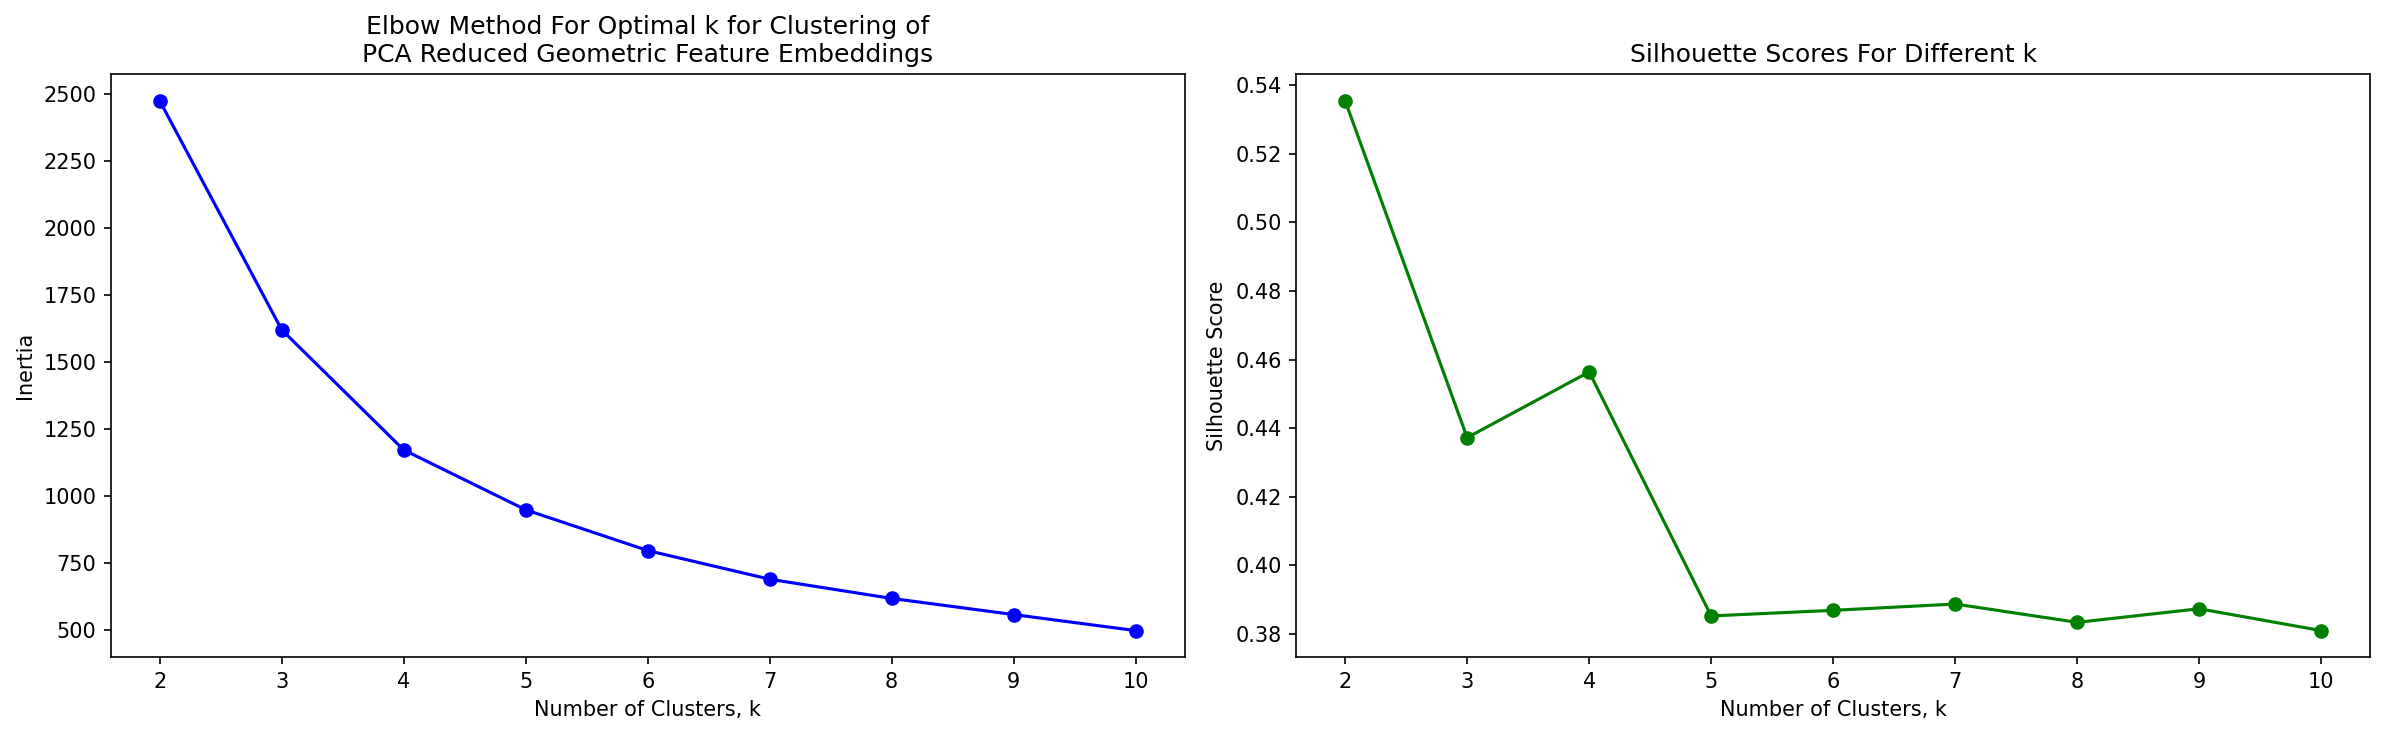

In [13]:
determine_optimal_clusters(pca_geometric_results, technique='PCA', features='Geometric')

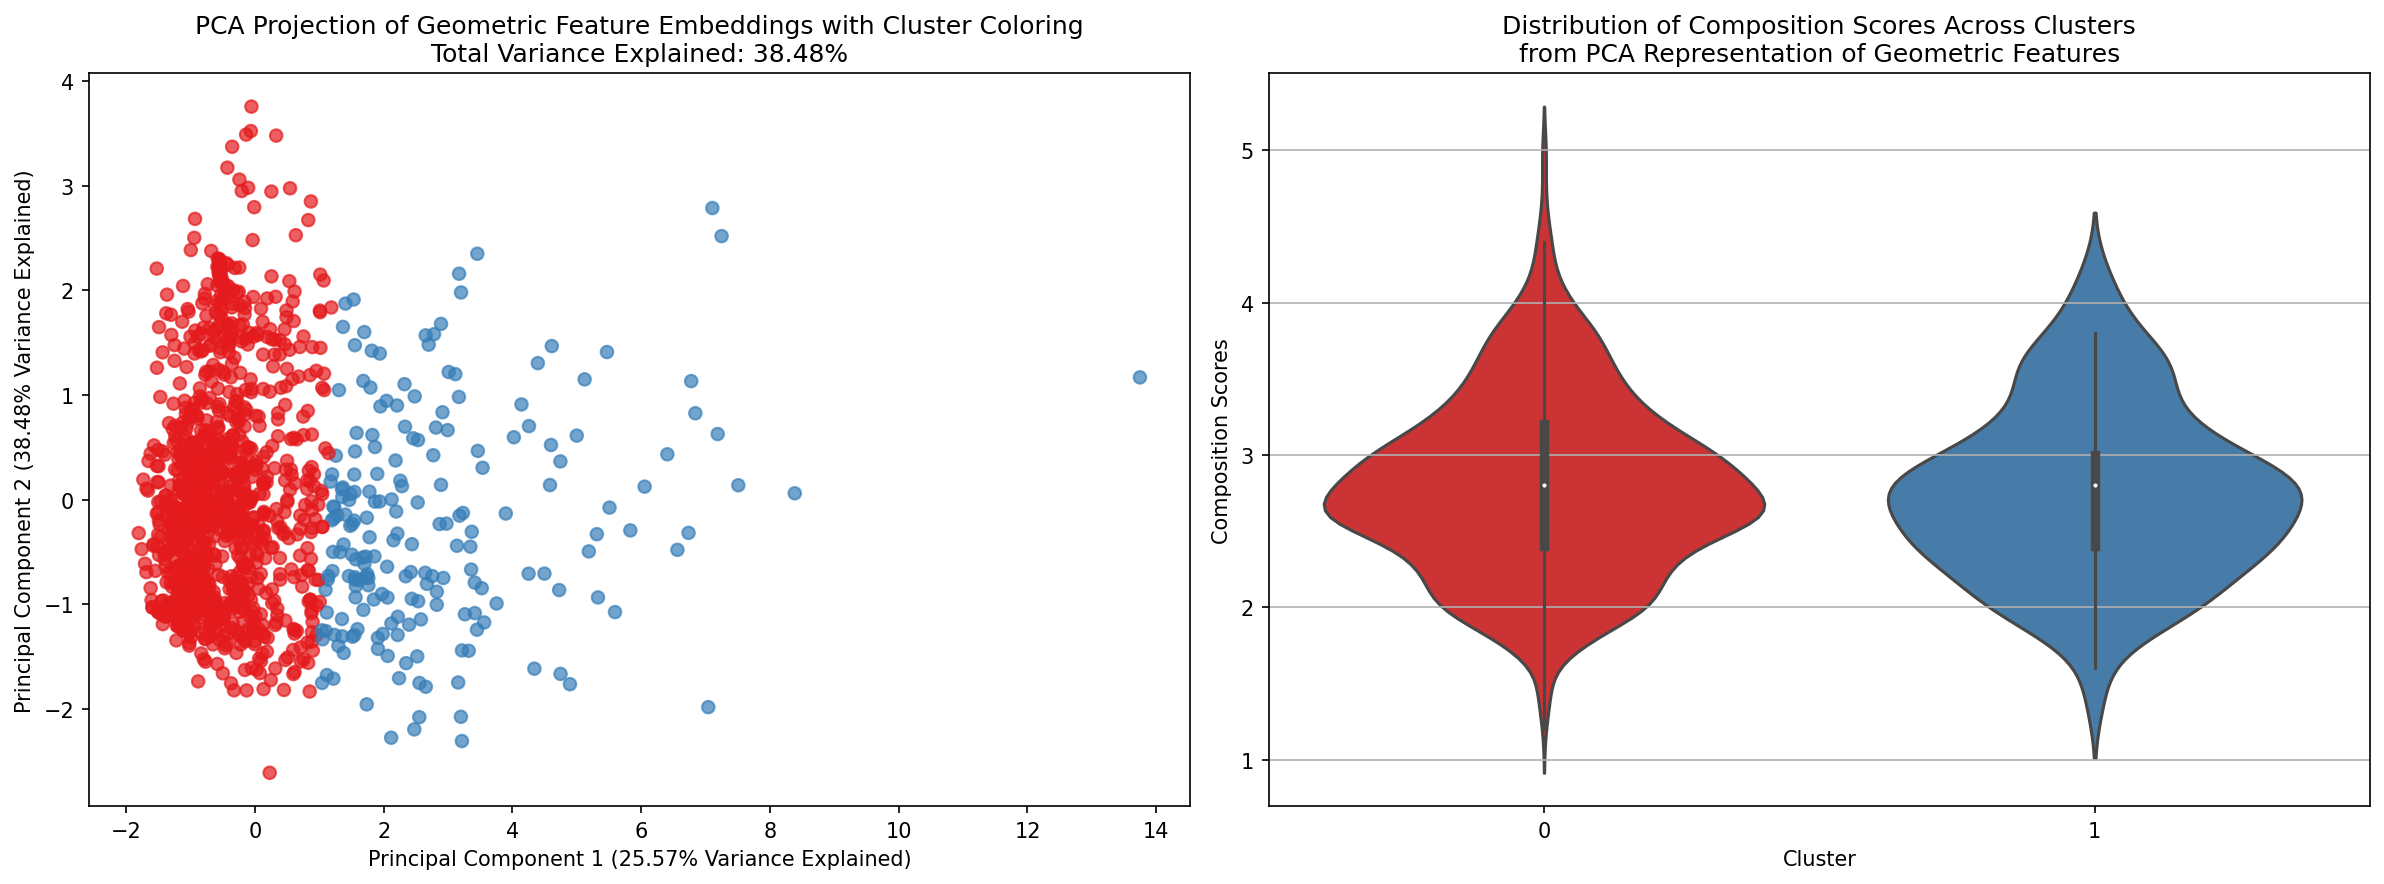

In [30]:
plot_clusters(pca_geometric_results, y_series, num_clusters=4, technique='PCA', features='Geometric', pca_object=pca_geometric)

### Clustering on TNSE Geometric Feature Manifold Representation

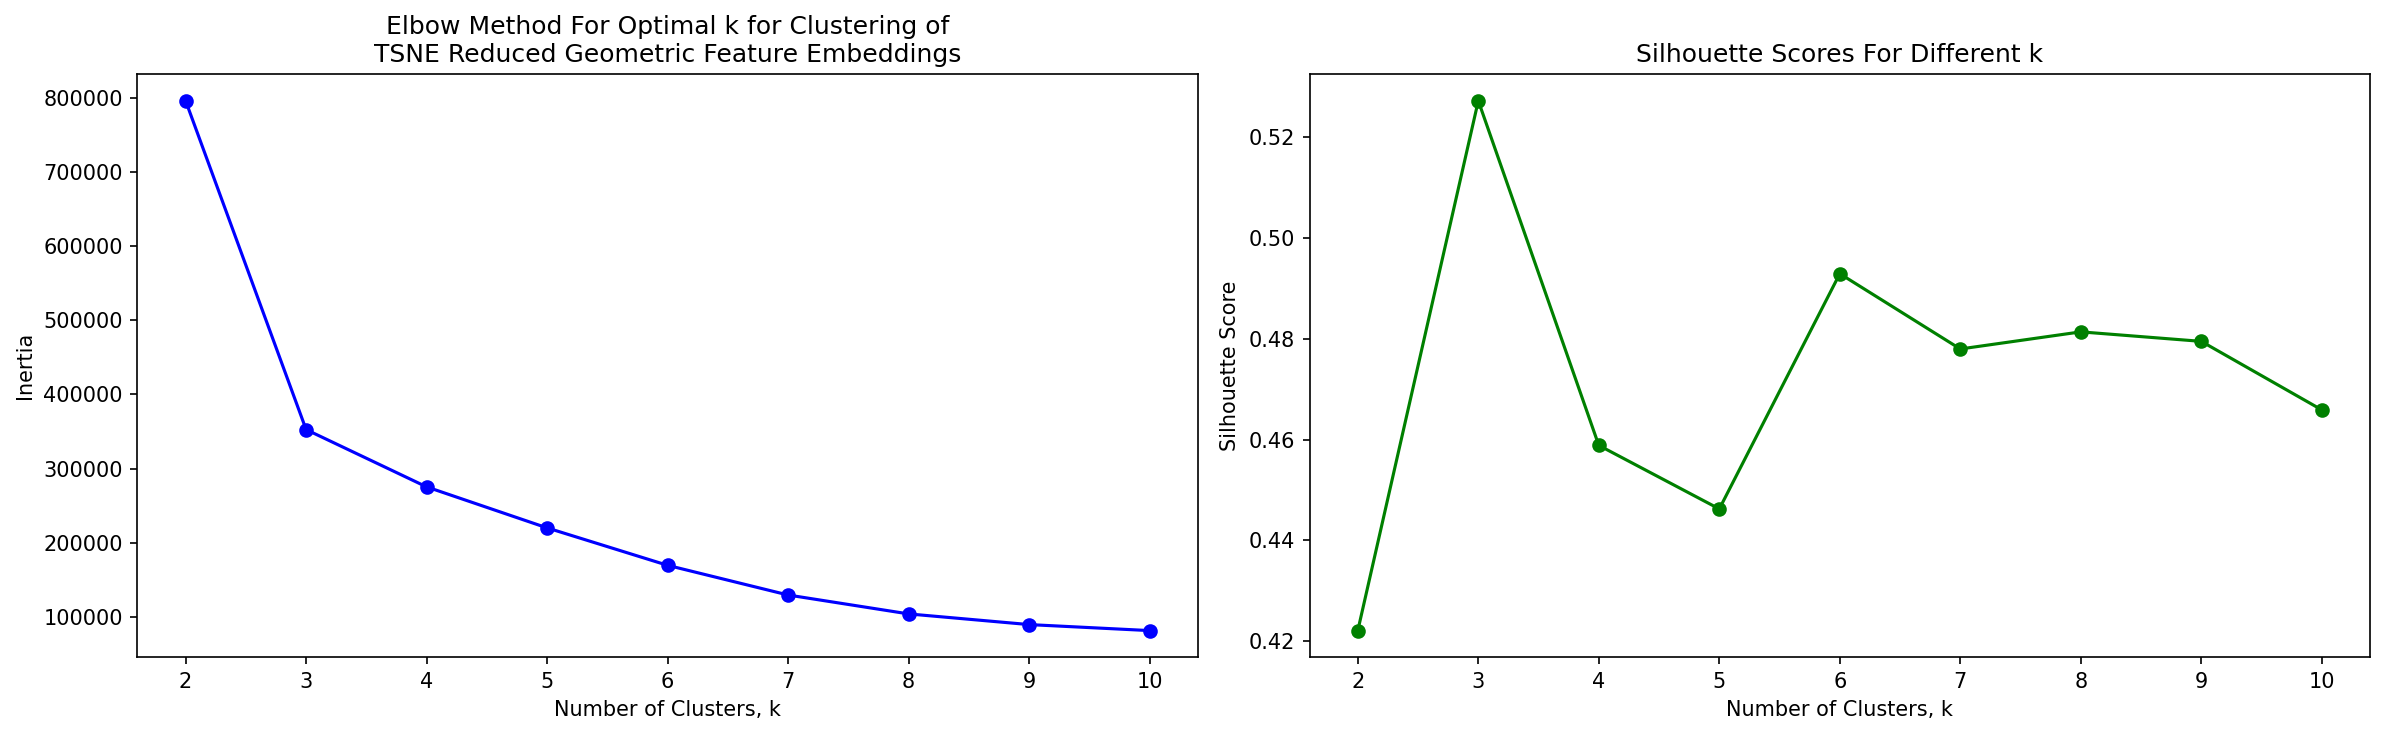

In [15]:
determine_optimal_clusters(tsne_geometric_results, technique='TSNE', features='Geometric')

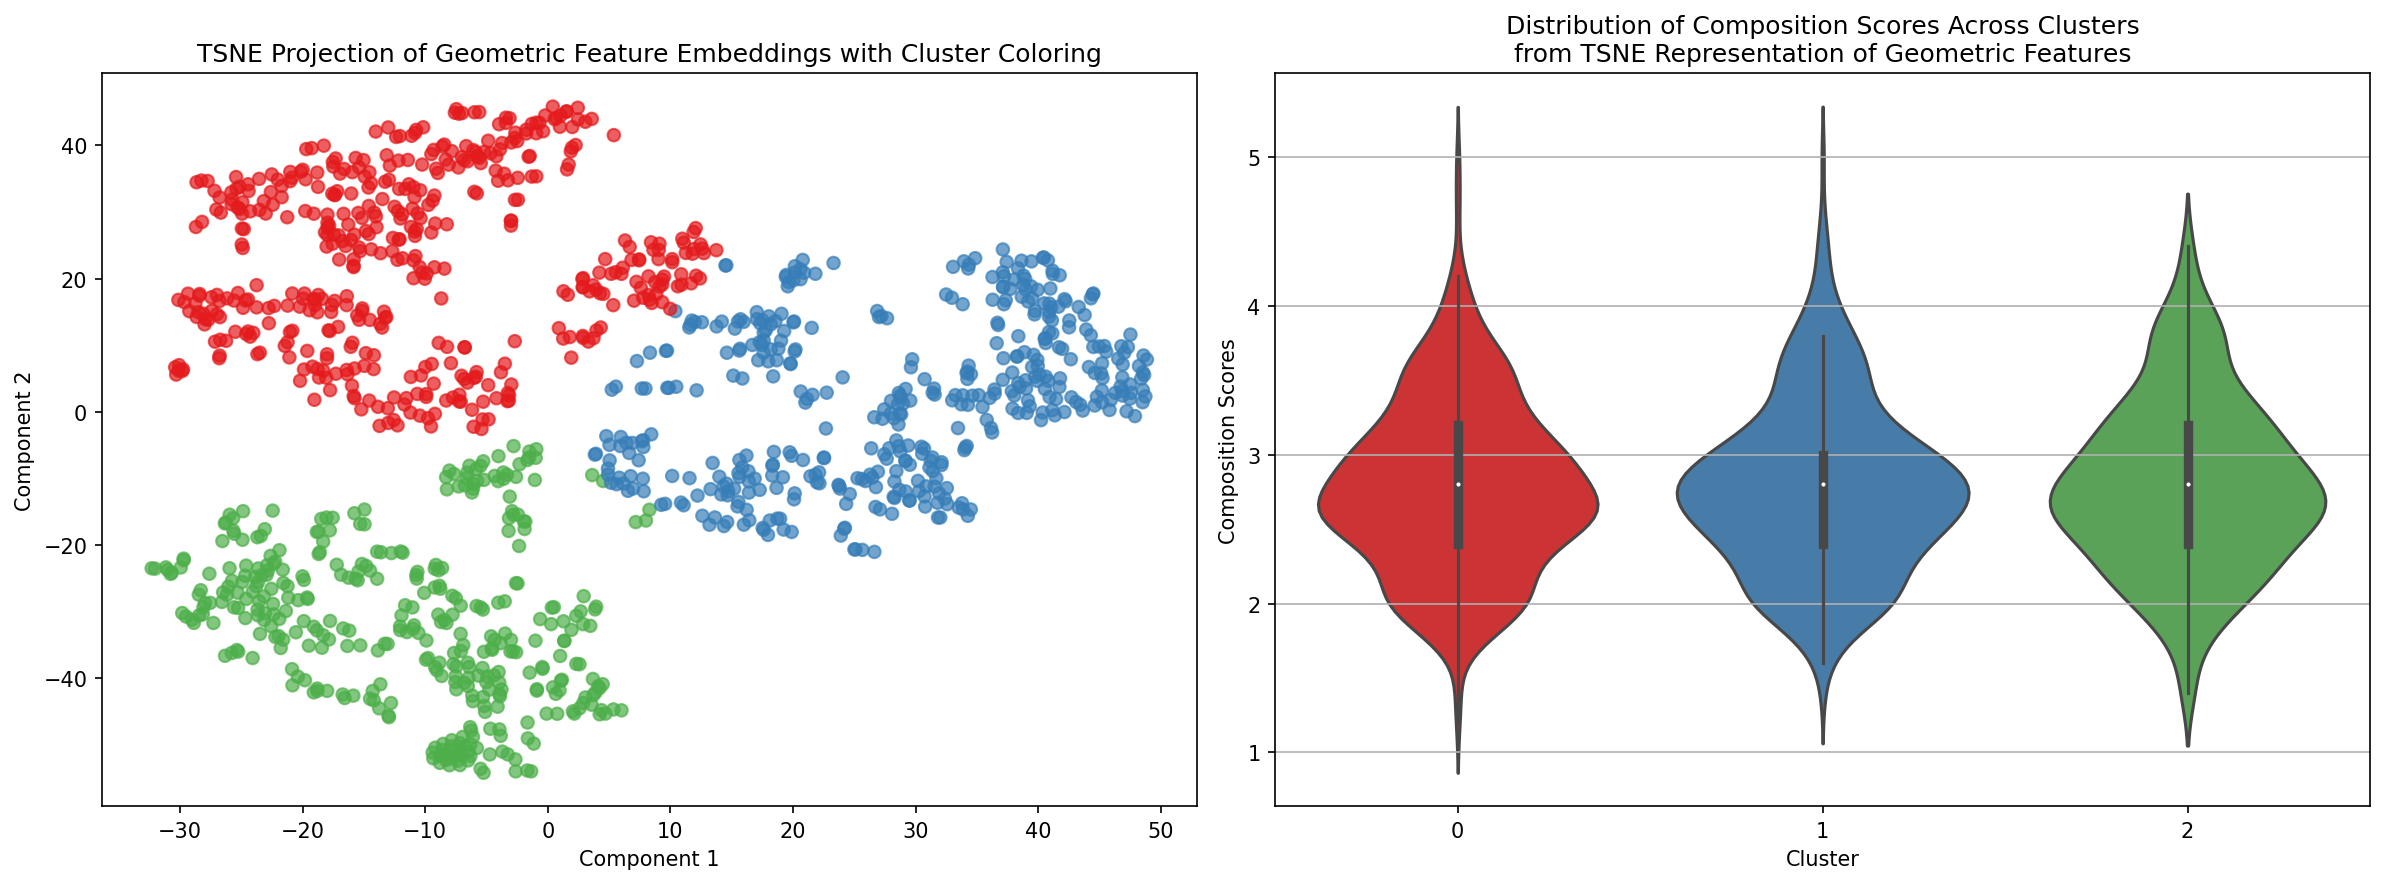

In [16]:
plot_clusters(tsne_geometric_results, y_series, num_clusters=3, technique='TSNE', features='Geometric')

### Clustering on UMAP Geometric Feature Manifold Representation

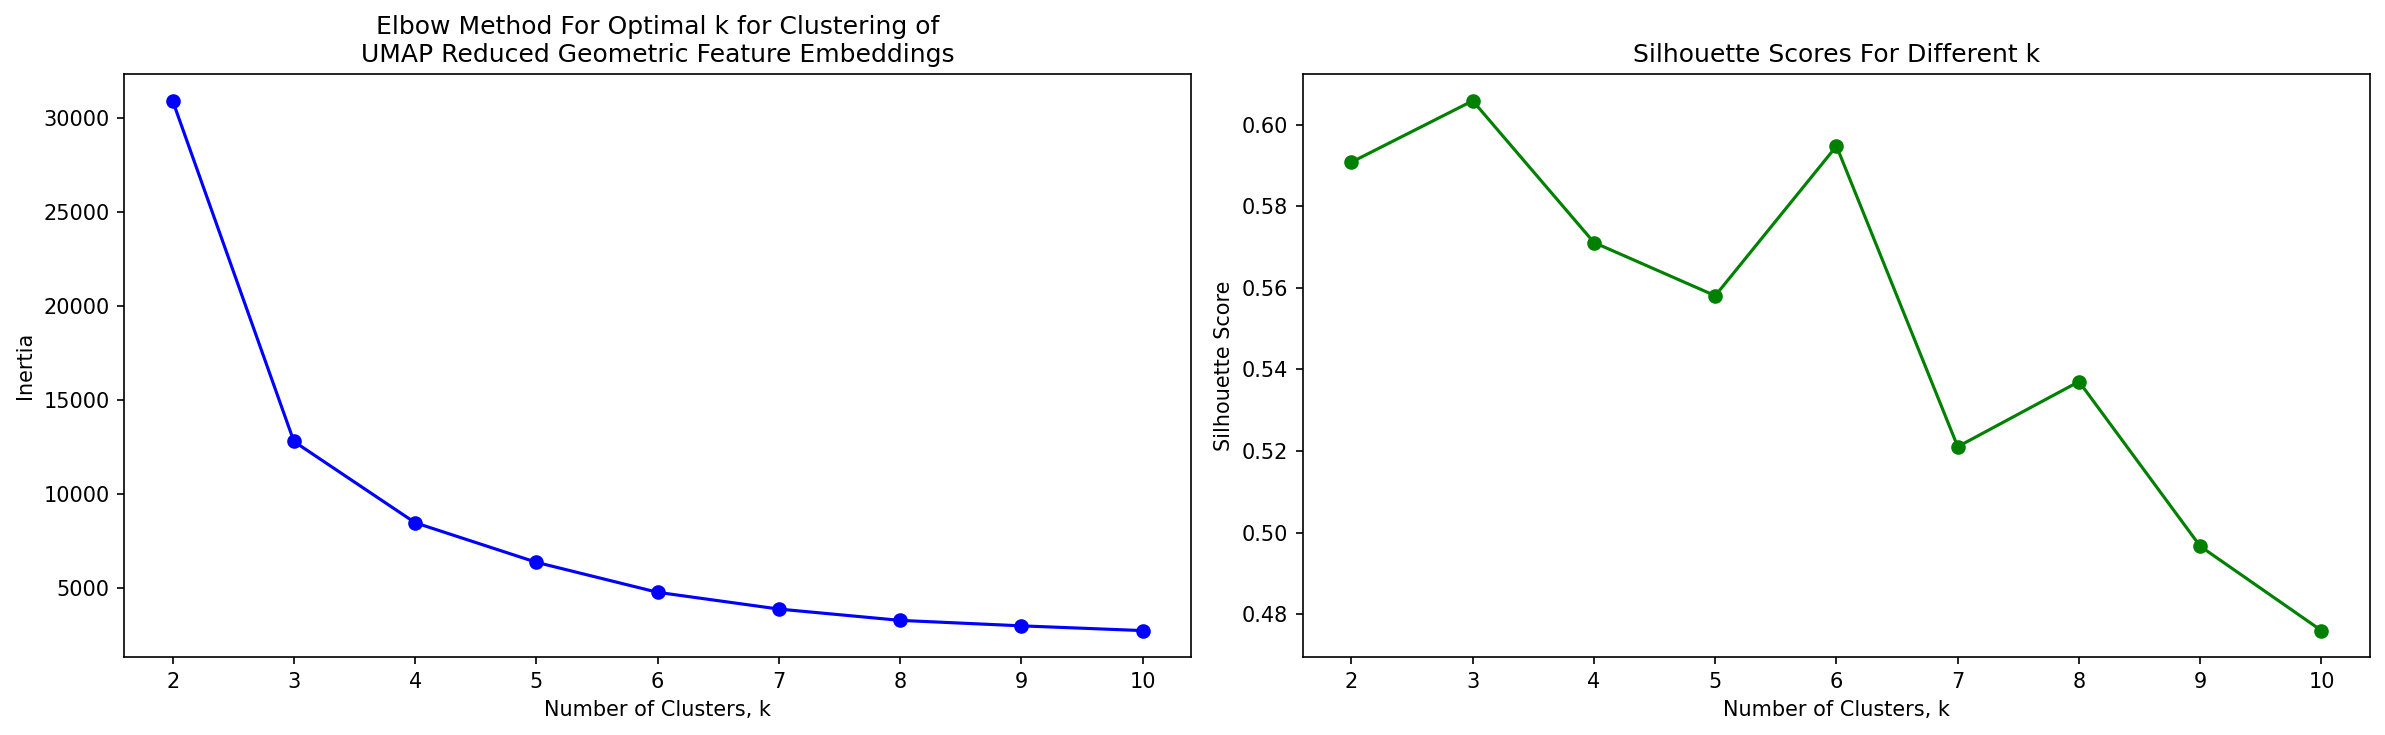

In [17]:
determine_optimal_clusters(umap_geometric_results, technique='UMAP', features='Geometric')

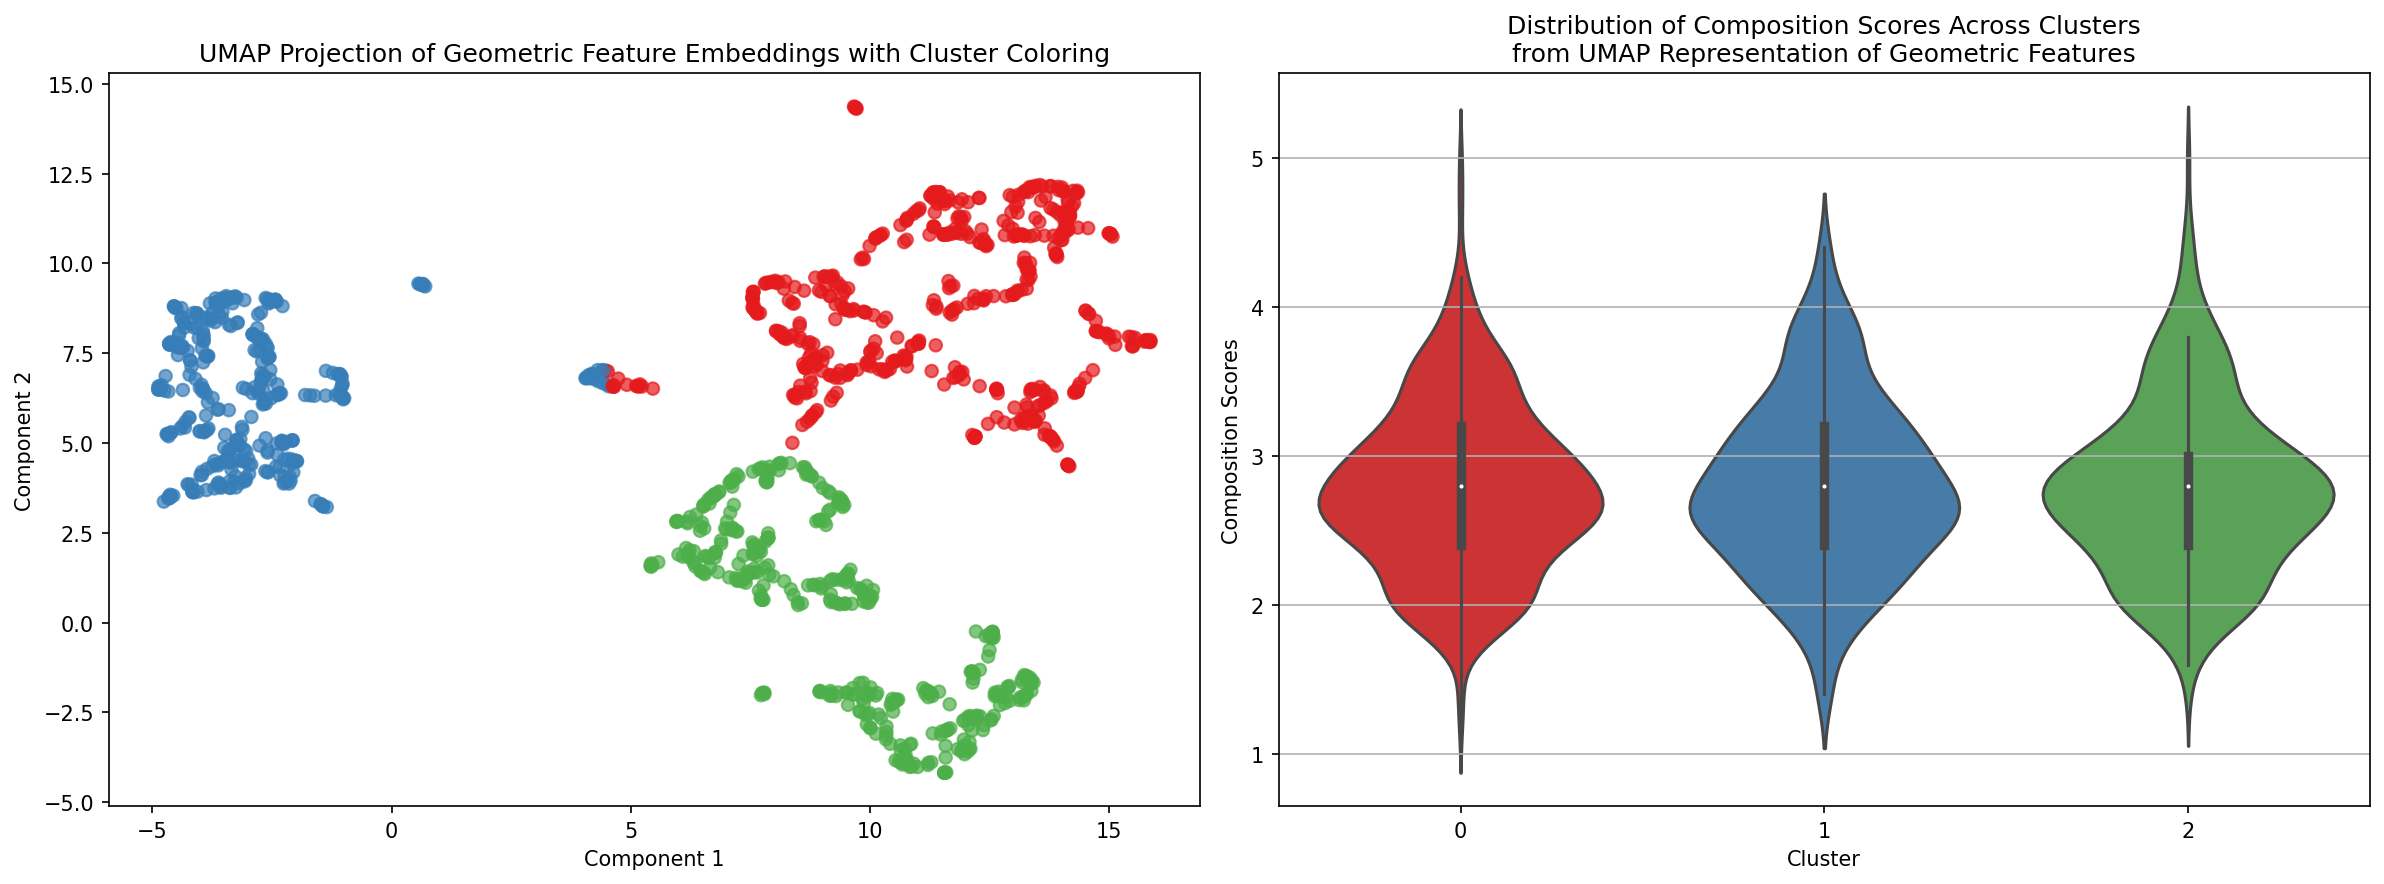

In [29]:
plot_clusters(umap_geometric_results, y_series, num_clusters=3, technique='UMAP', features='Geometric')

## Clustering of Low-dimensional Combined Feature Embeddings

### Clustering on PCA Combined Feature Manifold Representation

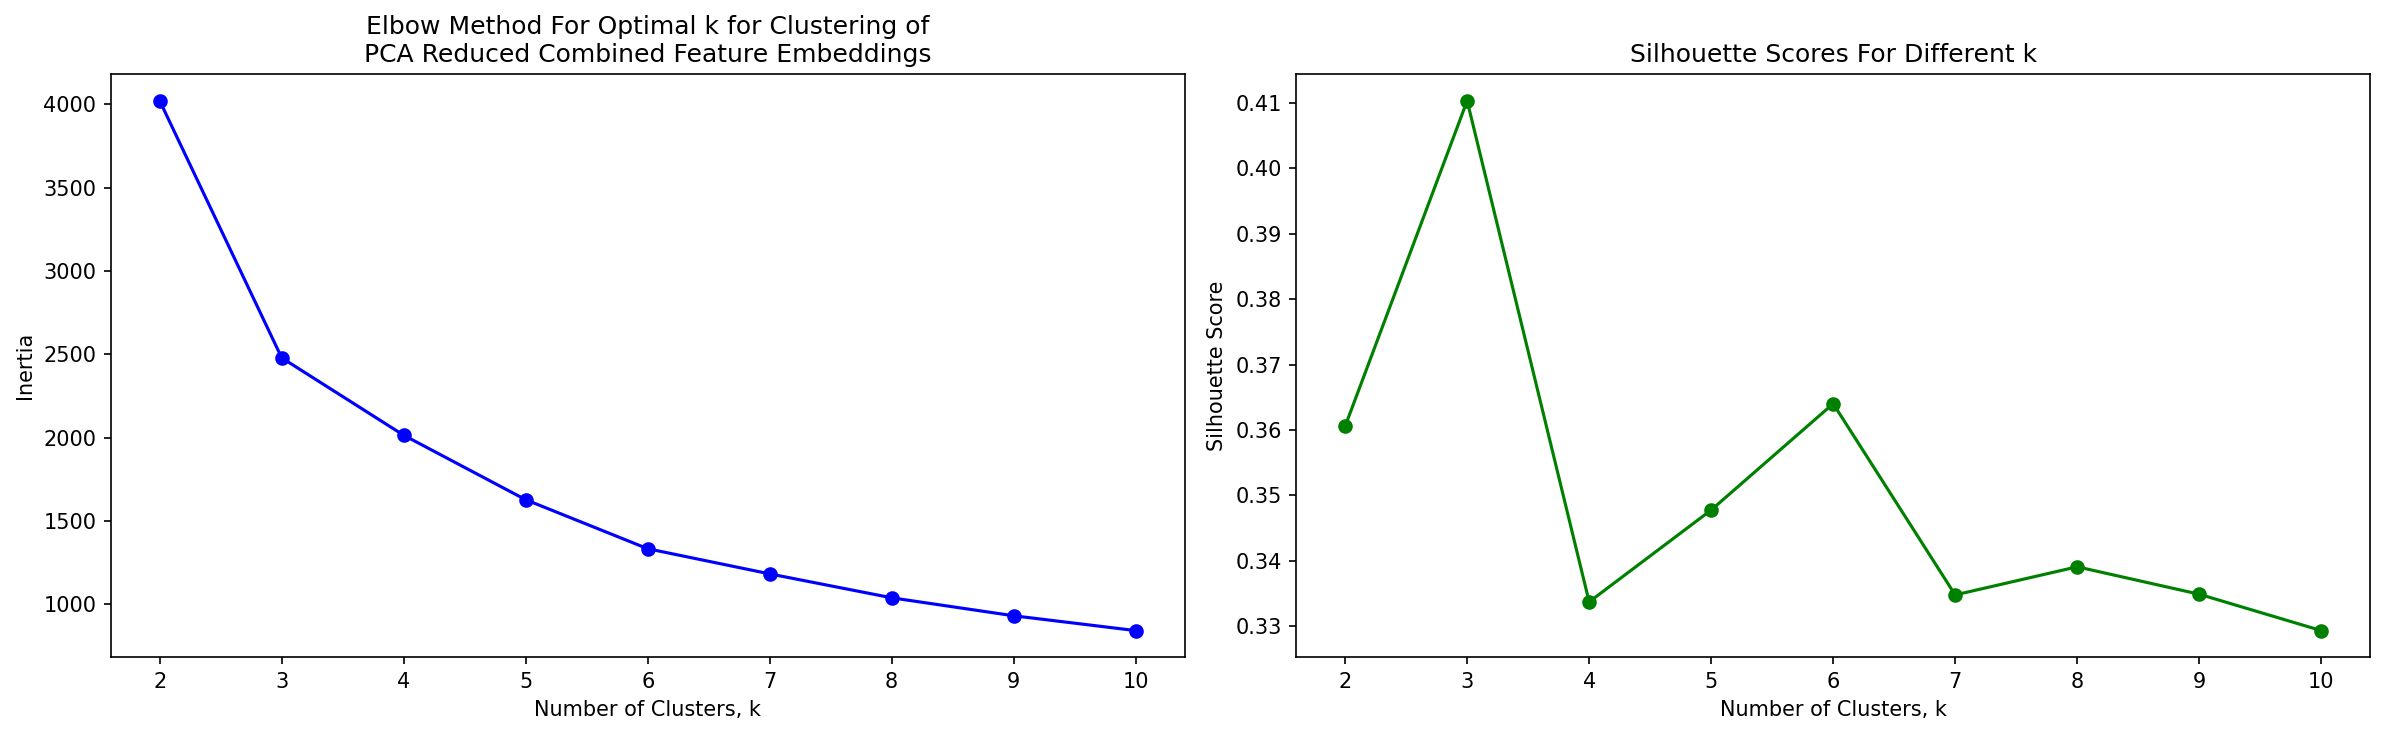

In [19]:
determine_optimal_clusters(pca_combined_results, technique='PCA', features='Combined')

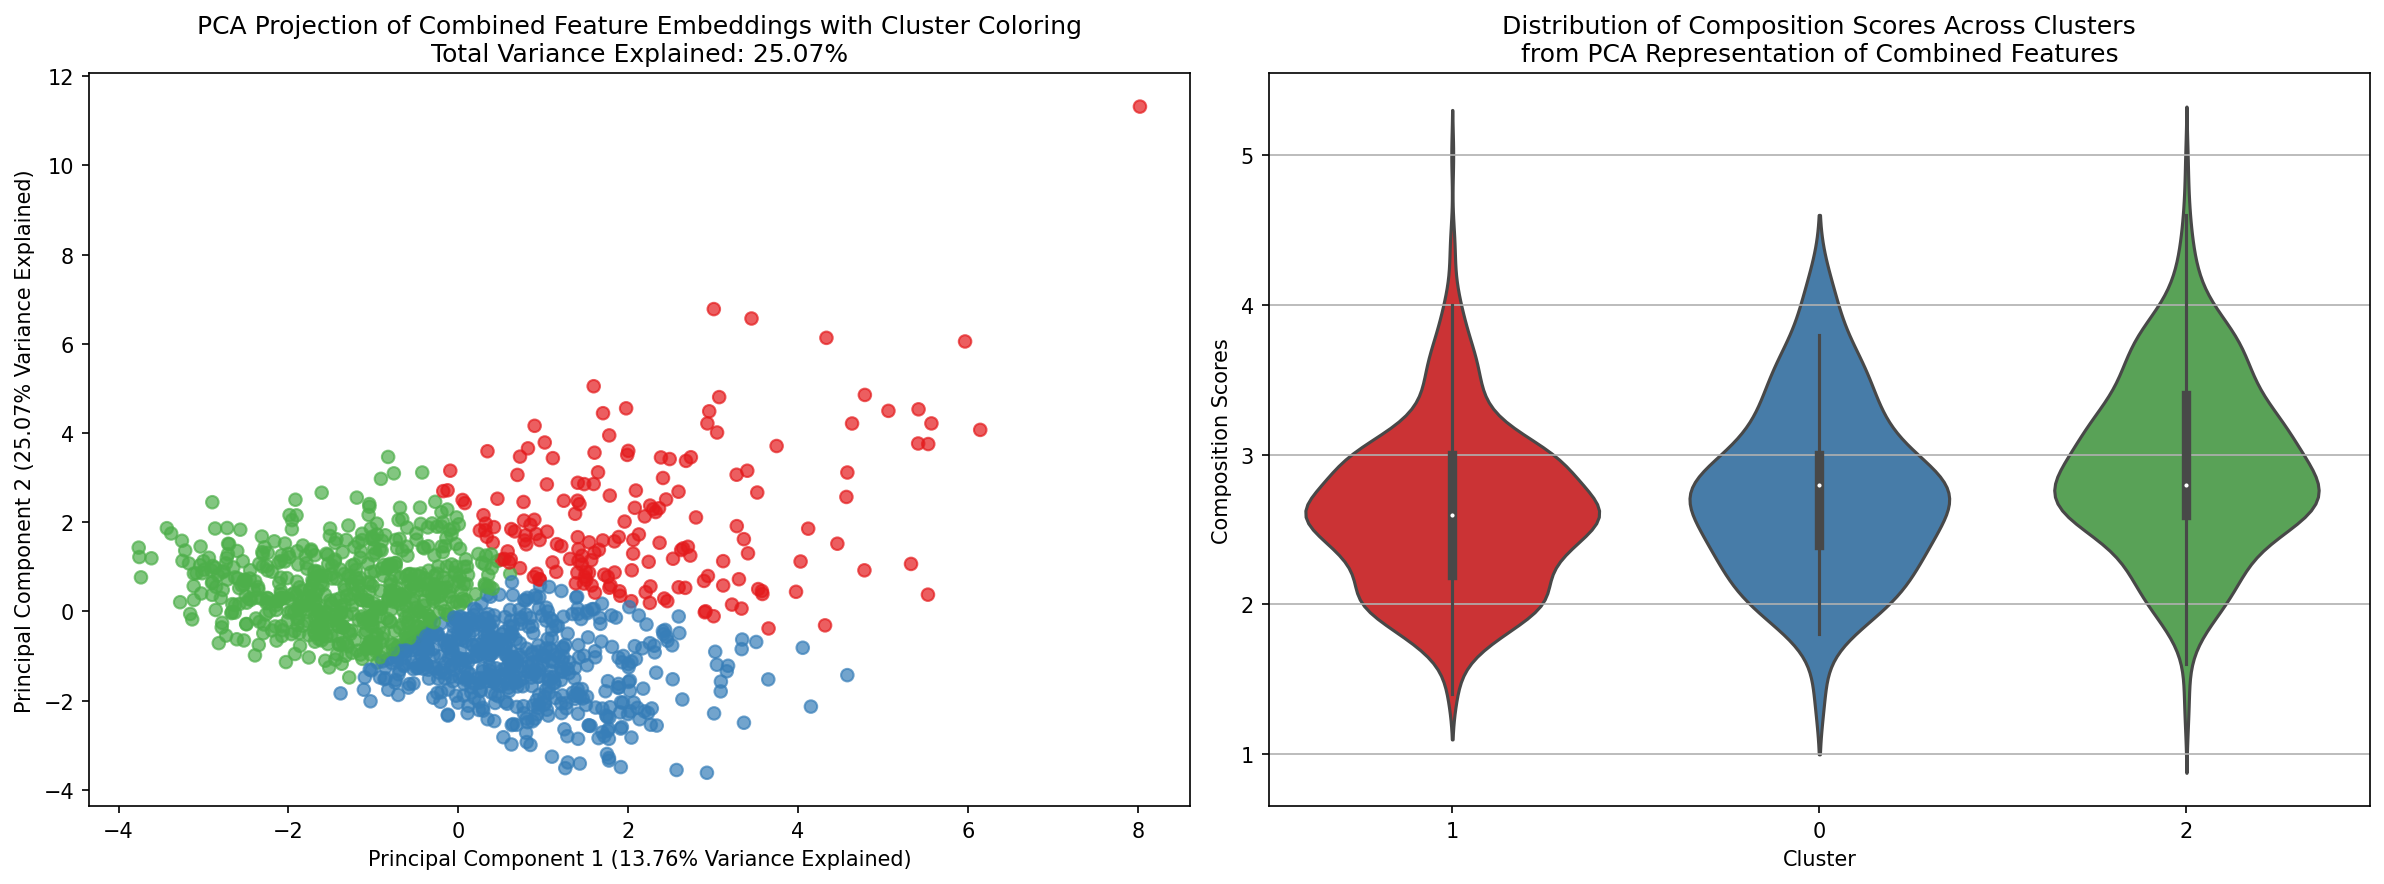

In [20]:
plot_clusters(pca_combined_results, y_series, num_clusters=3, technique='PCA', features='Combined', pca_object=pca_combined)

### Clustering on TSNE Combined Feature Manifold Representation

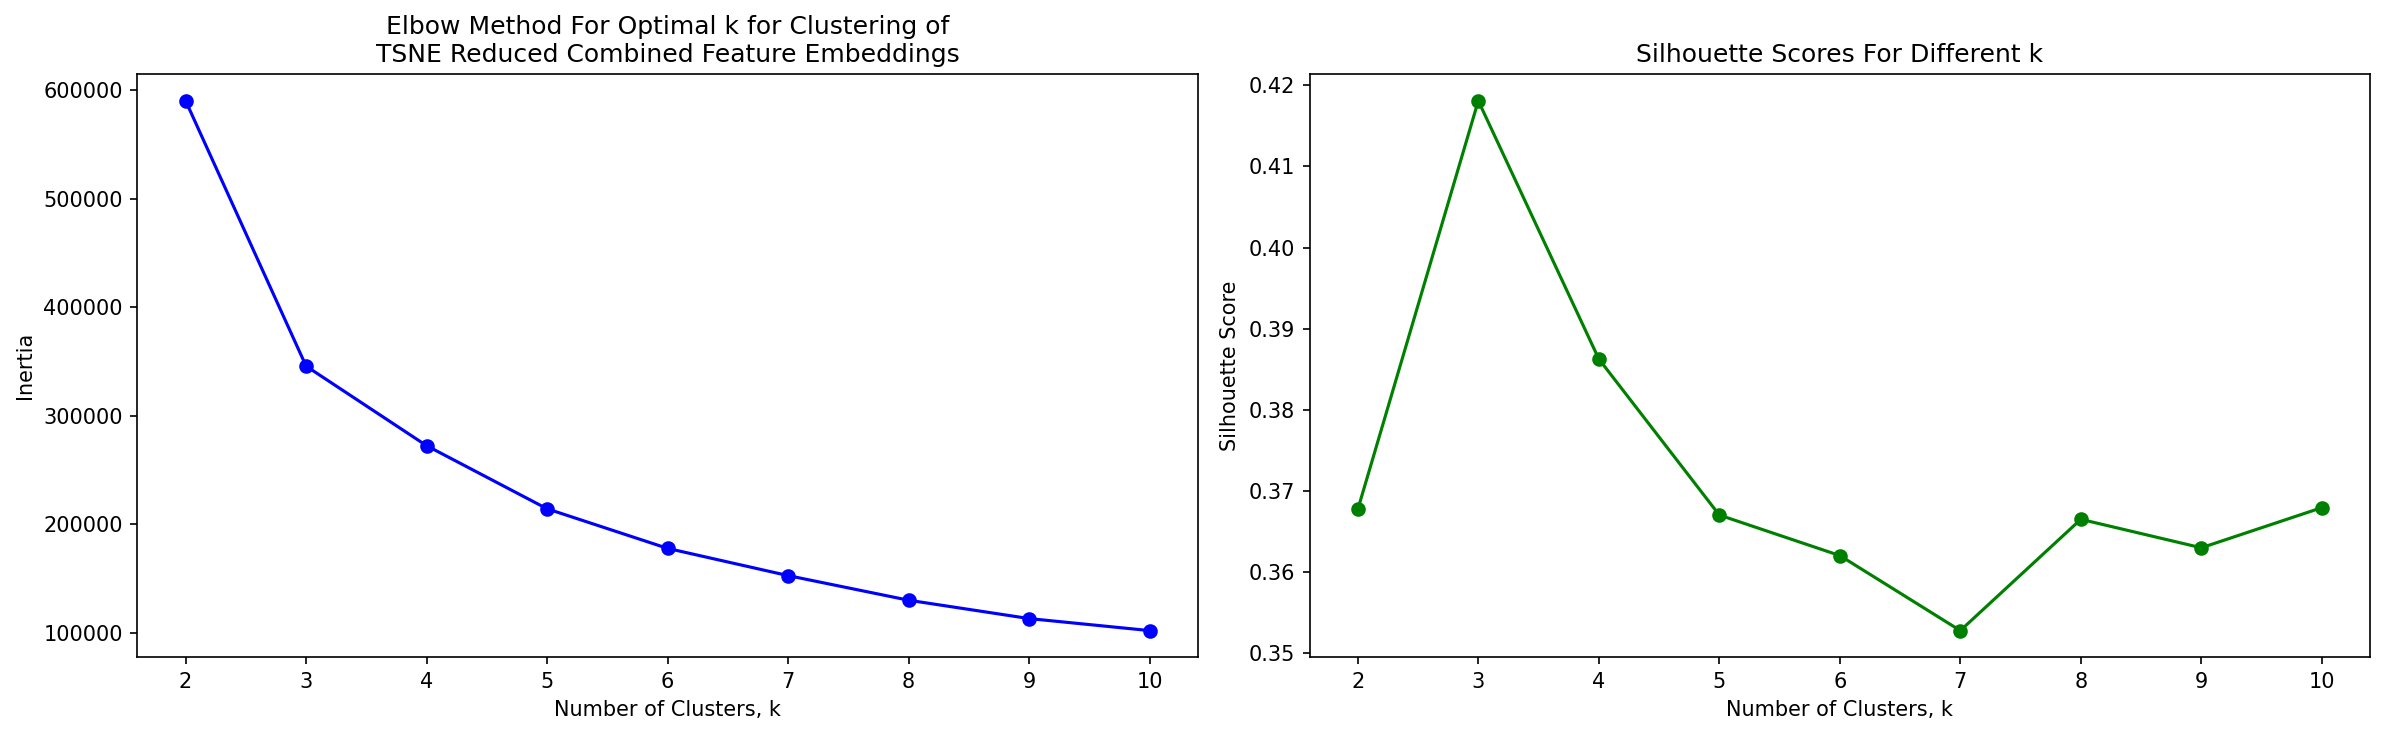

In [21]:
determine_optimal_clusters(tsne_combined_results, technique='TSNE', features='Combined')

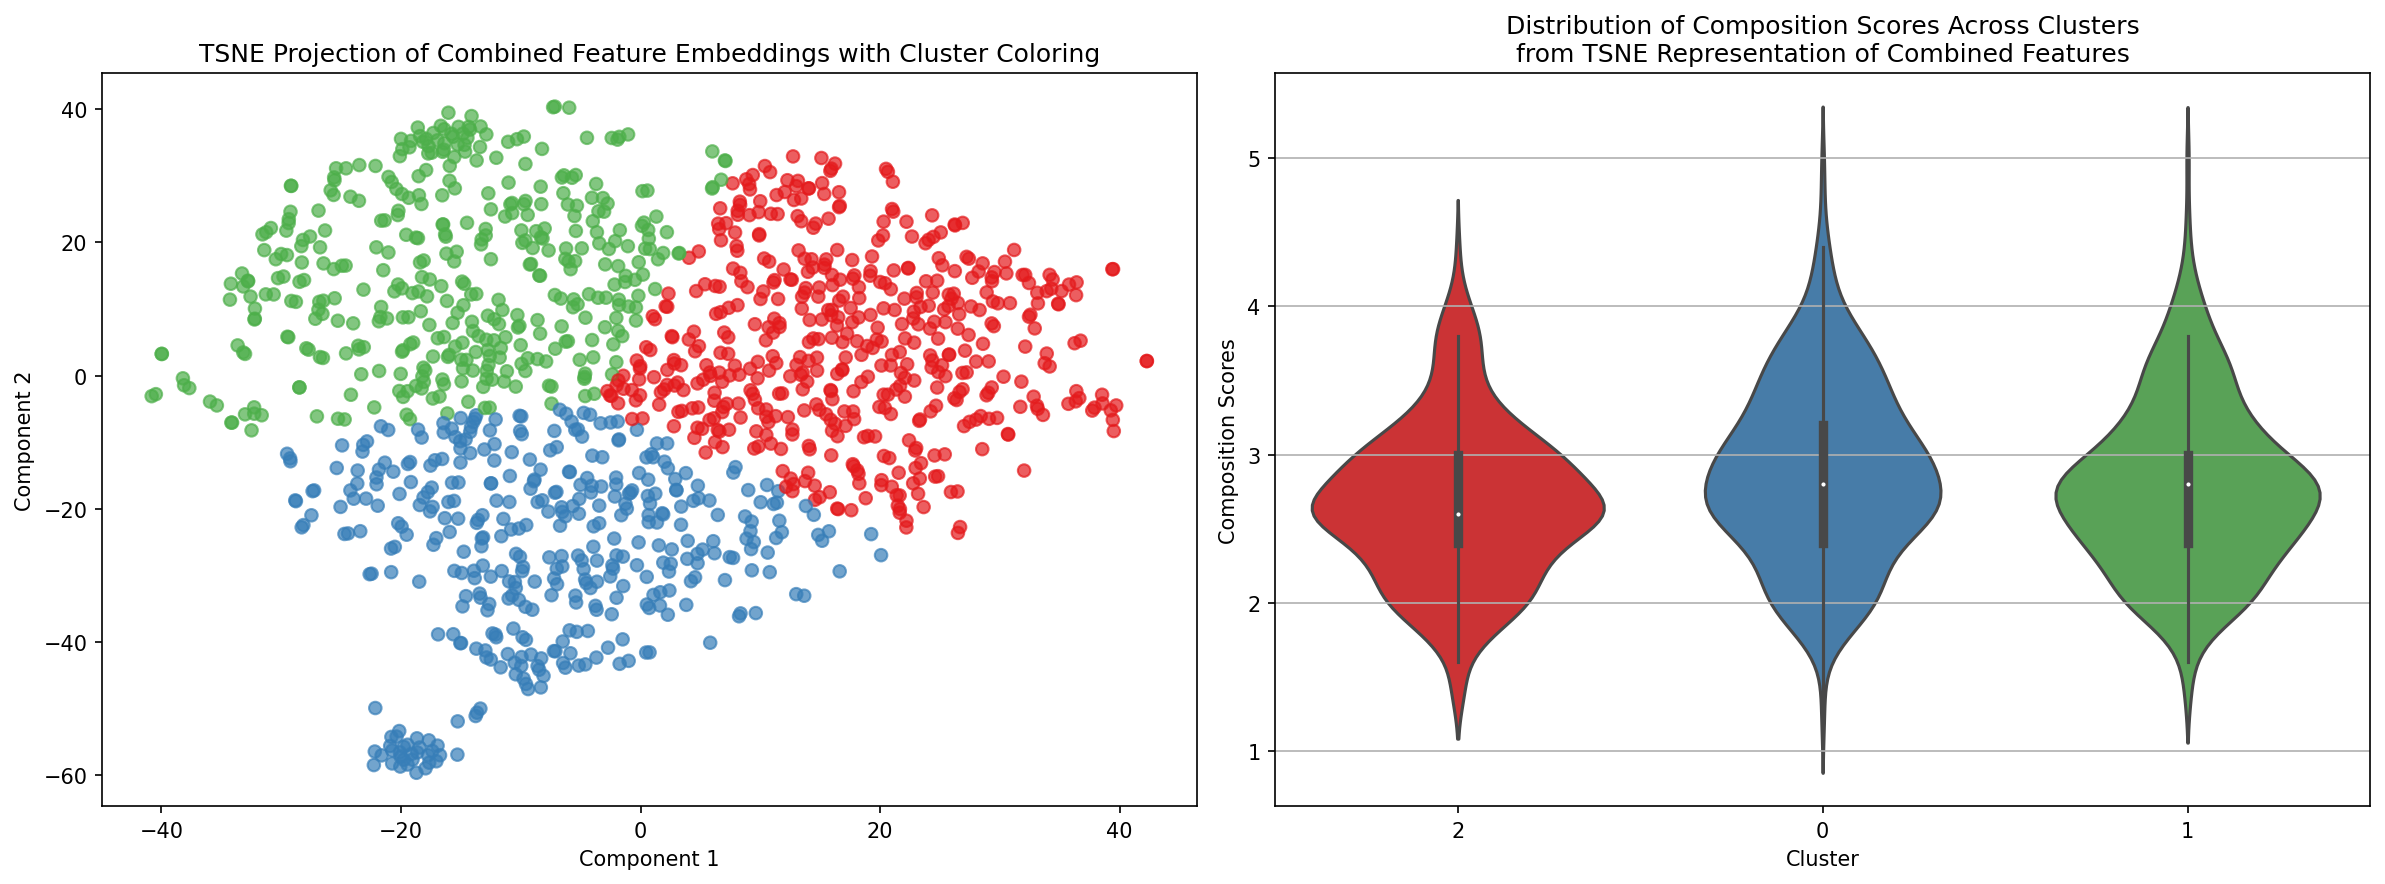

In [22]:
plot_clusters(tsne_combined_results, y_series, num_clusters=3, technique='TSNE', features='Combined')

### Clustering on UMAP Combined Feature Manifold Representation

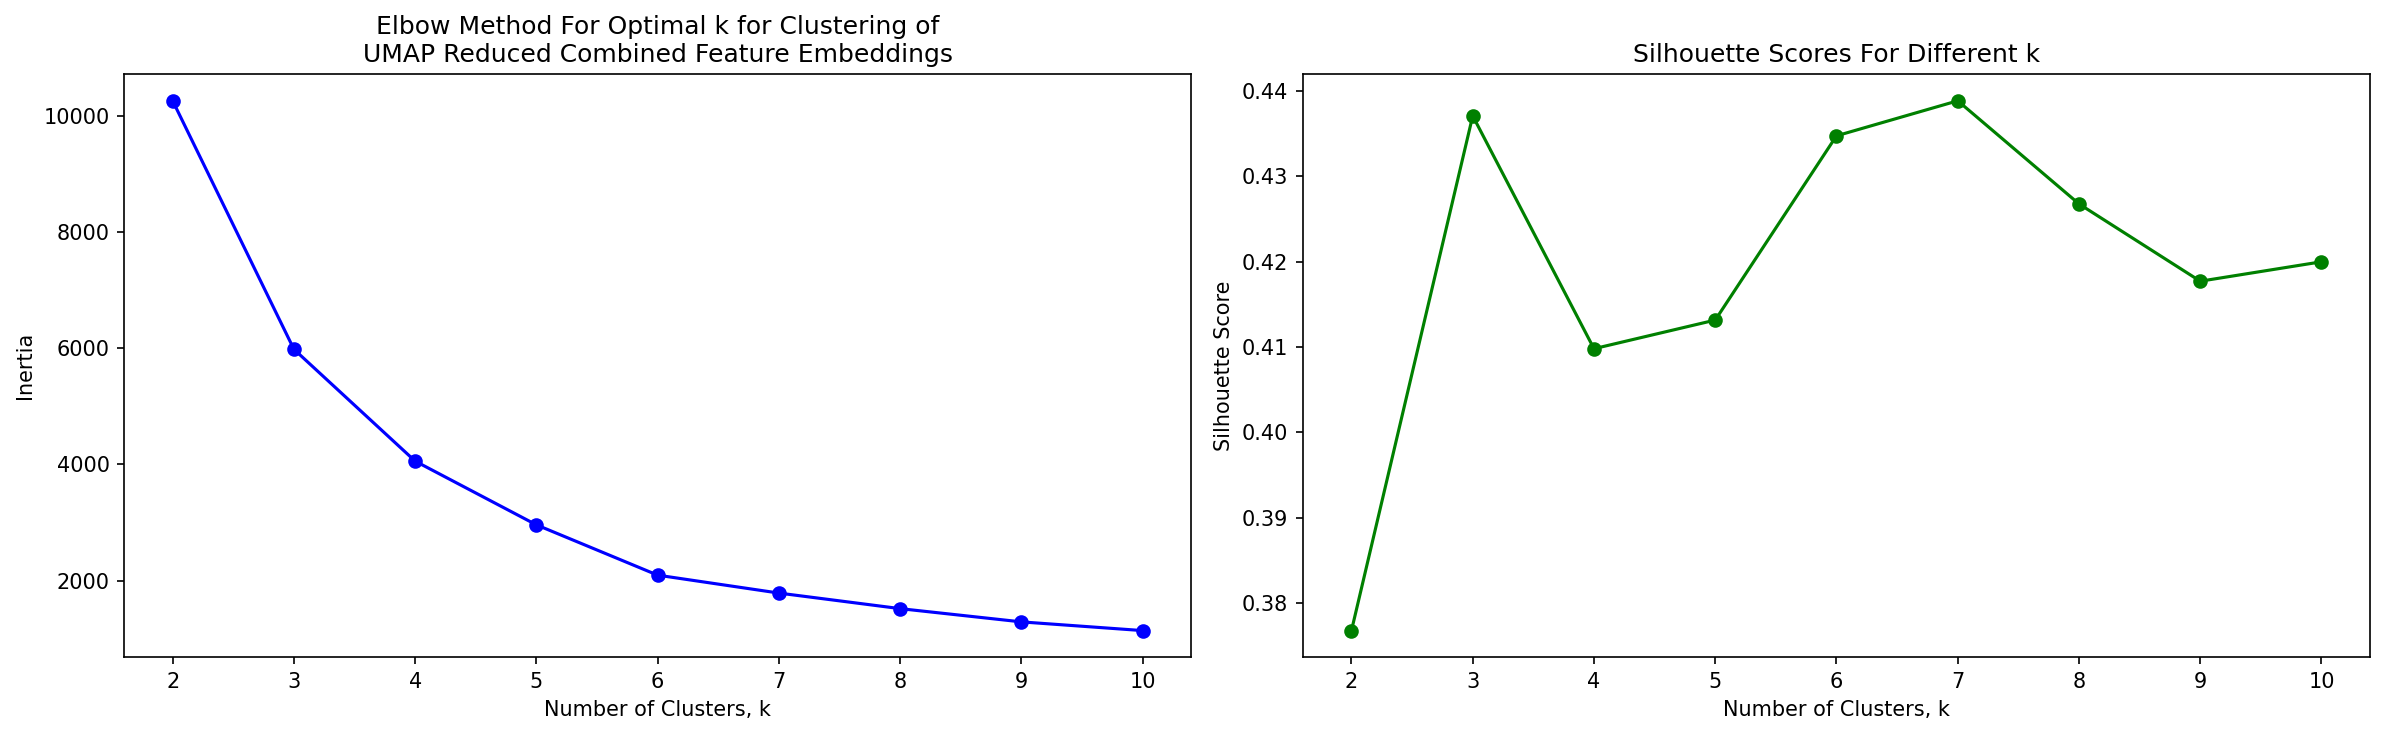

In [23]:
determine_optimal_clusters(umap_combined_results, technique='UMAP', features='Combined')

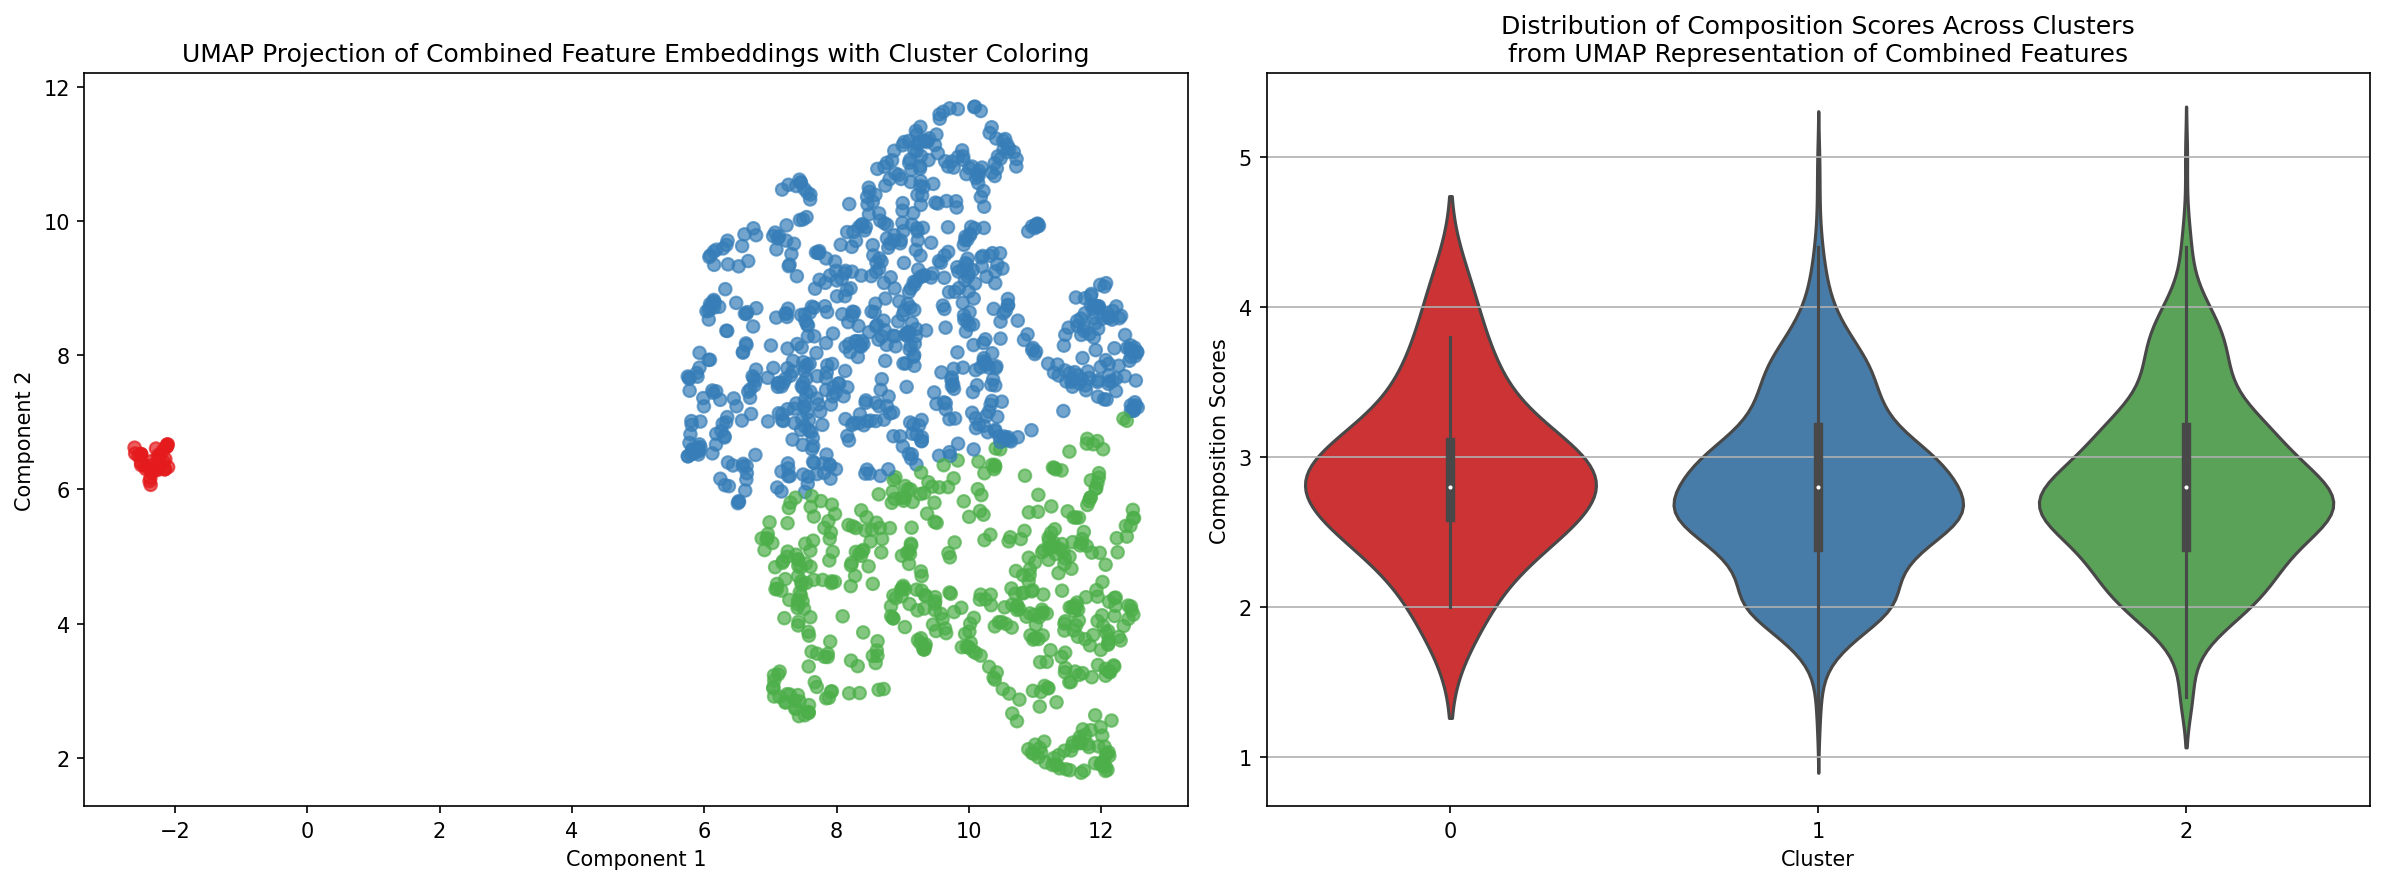

In [24]:
plot_clusters(umap_combined_results, y_series, num_clusters=3, technique='UMAP', features='Combined')

## ANOVA for Composition Scores in Resulting Clusters

In [25]:
# List of cluster columns
cluster_columns = ['Cluster_PCA_Geometric', 'Cluster_TSNE_Geometric',
                   'Cluster_UMAP_Geometric', 'Cluster_PCA_Combined',
                   'Cluster_TSNE_Combined', 'Cluster_UMAP_Combined']

anova_df = features_df[cluster_columns]
anova_df['composition_score'] = y_series
anova_df.head(5)

/var/folders/zc/mp9k67c5521c1f72_c1ffgdw0000gn/T/ipykernel_3100/85111962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['composition_score'] = y_series


Cluster_PCA_Geometric  Cluster_TSNE_Geometric  Cluster_UMAP_Geometric  \
0                      1                       0                       3   
1                      0                       2                       1   
2                      0                       2                       1   
3                      1                       0                       2   
4                      1                       0                       3   

   Cluster_PCA_Combined  Cluster_TSNE_Combined  Cluster_UMAP_Combined  \
0                     1                      0                      1   
1                     2                      0                      1   
2                     1                      2                      2   
3                     2                      0                      1   
4                     1                      0                      1   

   composition_score  
0                2.8  
1                3.2  
2                3.2  
3                2.4  
4                2.4

ANOVA for Cluster_PCA_Geometric: F-statistic = 0.3224, p-value = 0.8092
ANOVA for Cluster_TSNE_Geometric: F-statistic = 0.2041, p-value = 0.8154
ANOVA for Cluster_UMAP_Geometric: F-statistic = 0.3657, p-value = 0.8332
ANOVA for Cluster_PCA_Combined: F-statistic = 48.2478, p-value = 6.224e-21
ANOVA for Cluster_TSNE_Combined: F-statistic = 14.7198, p-value = 4.778e-07
ANOVA for Cluster_UMAP_Combined: F-statistic = 0.6106, p-value = 0.5432


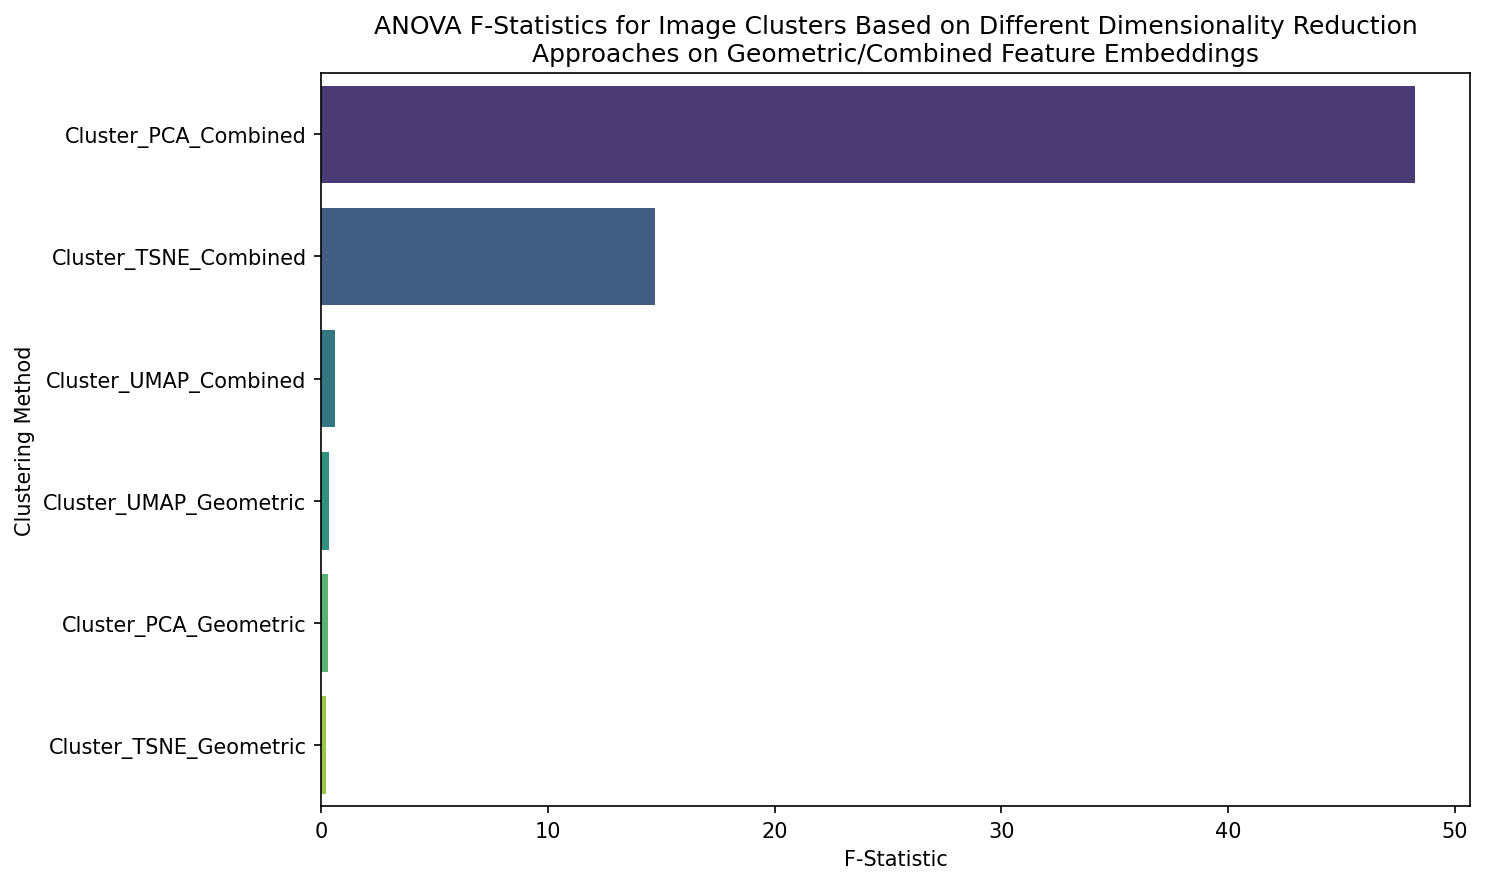

In [33]:
# Function to perform ANOVA and return results
def perform_anova(df, cluster_col):
    groups = df.groupby(cluster_col)['composition_score'].apply(list)
    anova_result = f_oneway(*groups)
    print(f'ANOVA for {cluster_col}: F-statistic = {anova_result.statistic:.4f}, p-value = {anova_result.pvalue:.4g}')
    return anova_result.statistic

# Apply ANOVA to each clustering approach and collect F-statistics
anova_results = {col: perform_anova(anova_df, col) for col in cluster_columns}

# Create a DataFrame for plotting
anova_results_df = pd.DataFrame(list(anova_results.items()), columns=['Clustering Method', 'F-Statistic'])

# Sorting the DataFrame by F-Statistic in descending order
anova_results_df = anova_results_df.sort_values(by='F-Statistic', ascending=False)

# Plotting the results with the sorted DataFrame
plt.figure(figsize=(10, 6), dpi=150)
sns.barplot(x='F-Statistic', y='Clustering Method', data=anova_results_df, palette='viridis')
plt.title('ANOVA F-Statistics for Image Clusters Based on Different Dimensionality Reduction\nApproaches on Geometric/Combined Feature Embeddings')
plt.xlabel('F-Statistic')
plt.ylabel('Clustering Method')
plt.tight_layout()
plt.savefig(f'../visualizations/ANOVA_results.png', bbox_inches='tight')
plt.show()


## Analysis of Principal Components of Image Embeddings
I perform feature importance analysis by examining:
- Loadings Analysis: Check the absolute loadings (coefficients) of each feature on the principal components. The loadings will reveal the importance of each feature in the component.
- Permutation Feature Importance: Randomly shuffle each feature and measure the decrease in a model metric. For PCA, one way to do this is by looking at the impact on the explained variance when each feature is permuted.


### PCA on Geometric Features

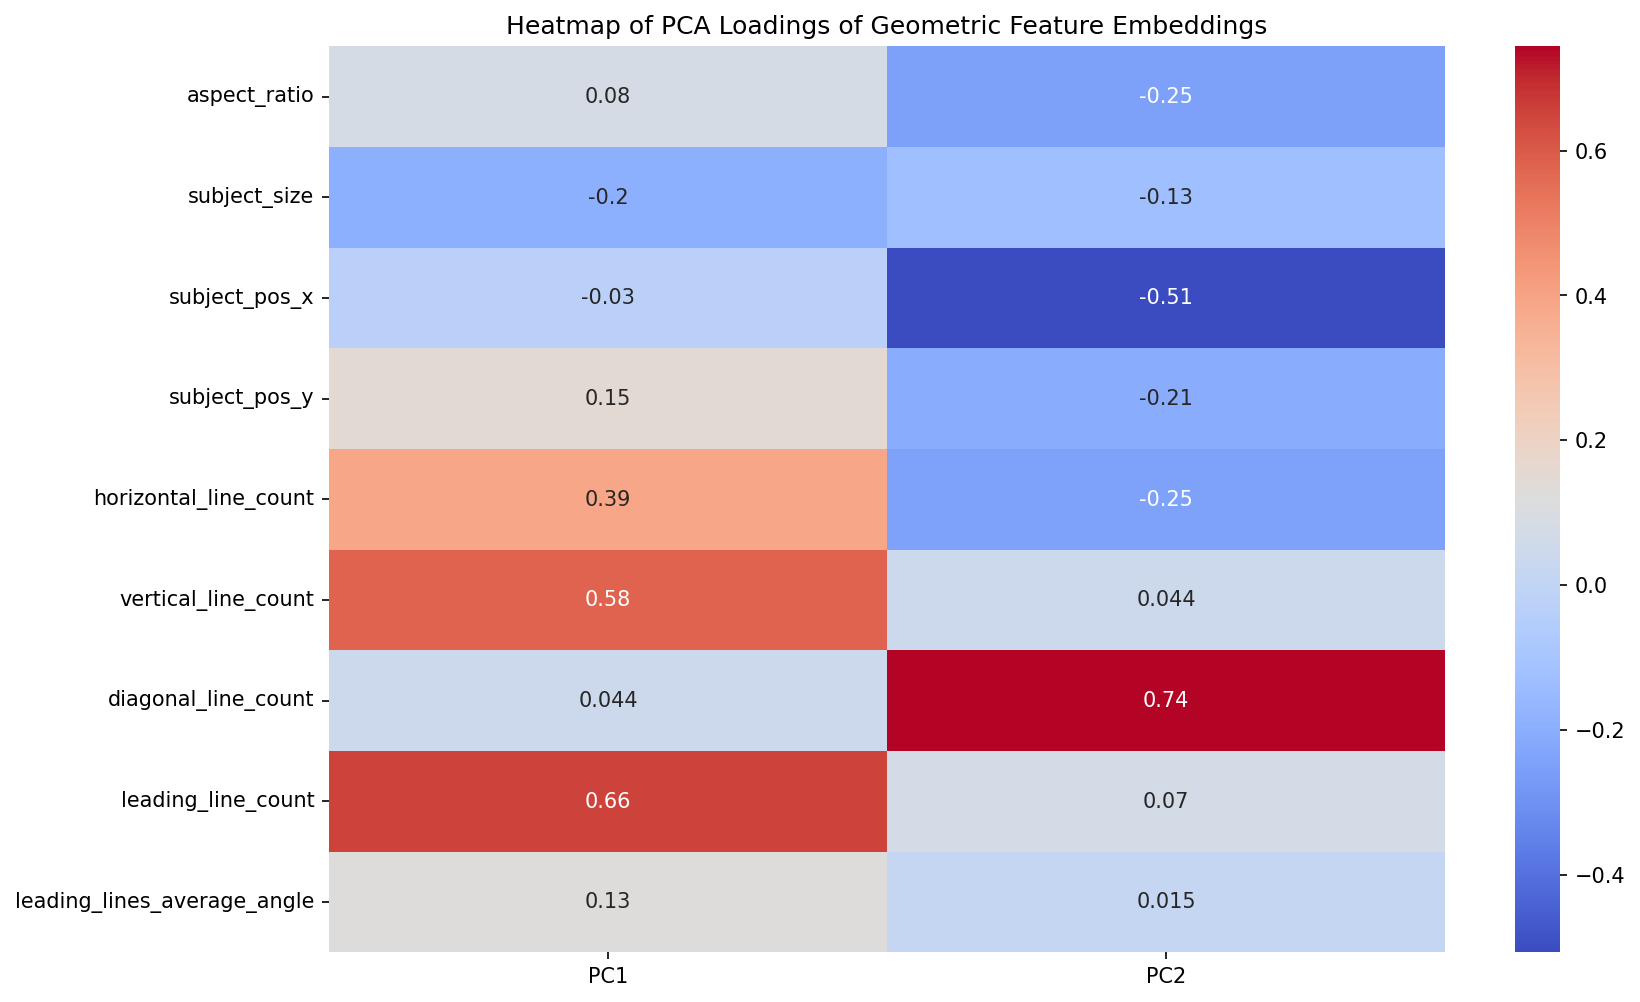

In [27]:
# Extract loadings
loadings = pd.DataFrame(pca_geometric.components_.T, columns=['PC1', 'PC2'], index=X_geometric.columns)

# Plot heatmap of loadings
import seaborn as sns
plt.figure(figsize=(12, 8), dpi=150)
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('Heatmap of PCA Loadings of Geometric Feature Embeddings')
plt.savefig('../visualizations/PCA_loadings_Geometric.png')
plt.show()

### PCA on Combined Features

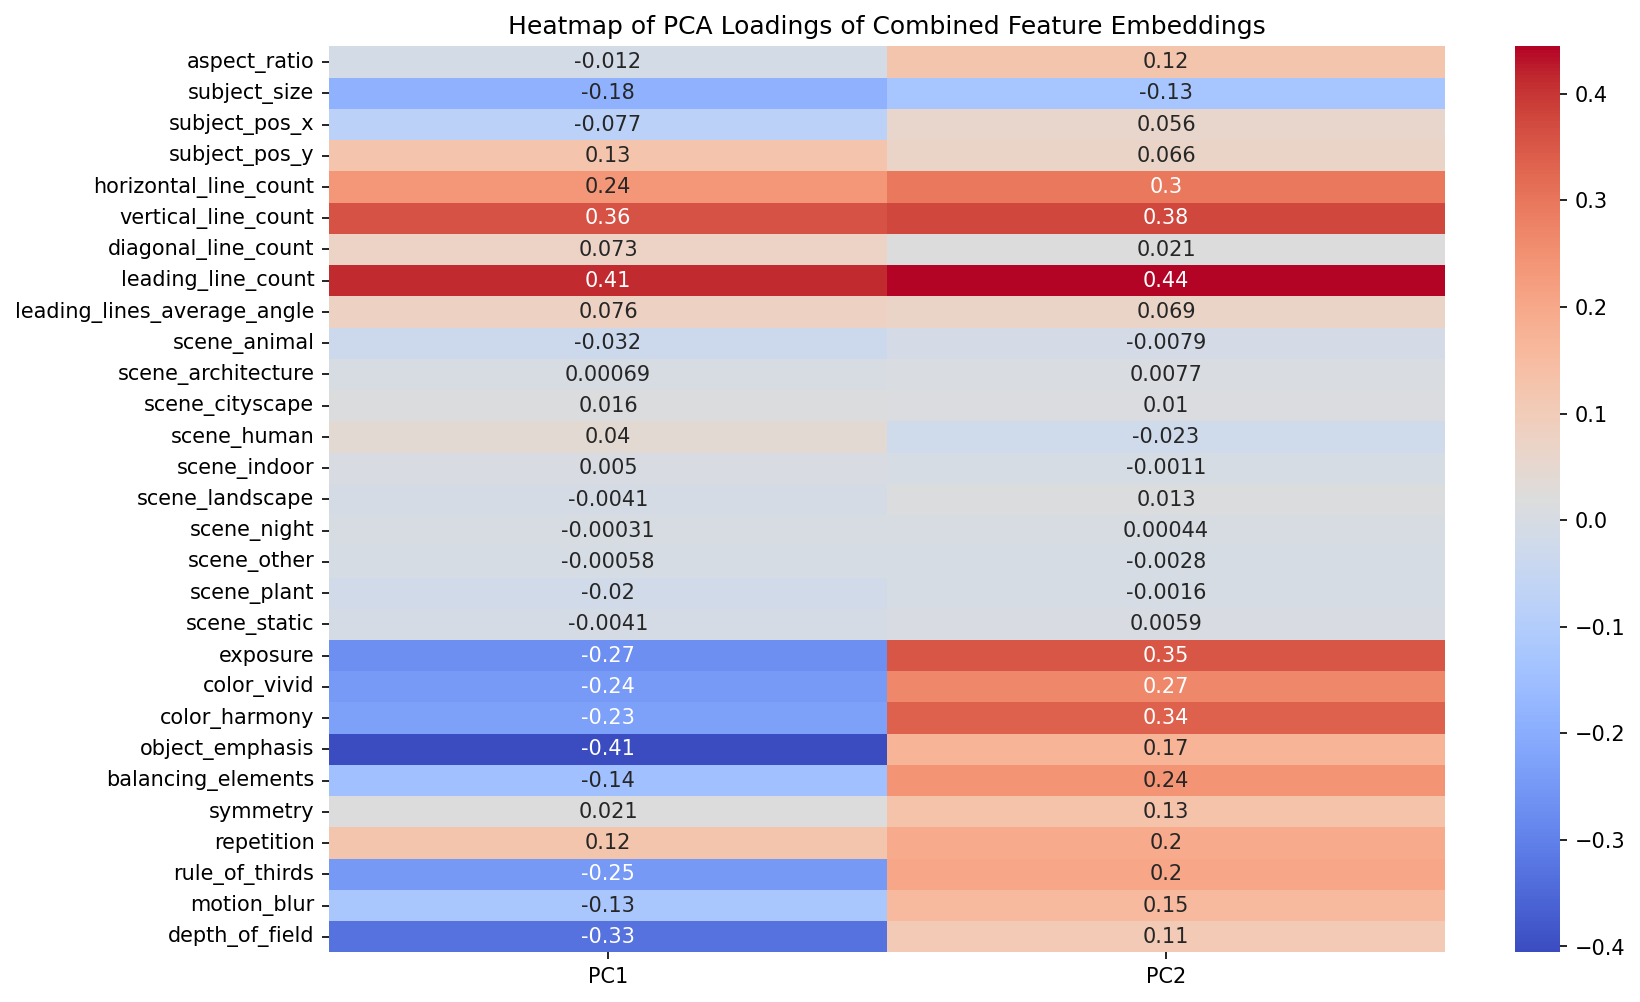

In [28]:
# Extract loadings
loadings = pd.DataFrame(pca_combined.components_.T, columns=['PC1', 'PC2'], index=X_combined.columns)

# Plot heatmap of loadings
import seaborn as sns
plt.figure(figsize=(12, 8), dpi=150)
sns.heatmap(loadings, annot=True, cmap='coolwarm')
plt.title('Heatmap of PCA Loadings of Combined Feature Embeddings')
plt.savefig('../visualizations/PCA_loadings_Combined.png')
plt.show()